# 0. Introduction

Team member: Jina Kim, Rahul Singh

**Task: fake news text classification**

1. Workplace Setup
2. Data Cleaning
3. Preprocessing Text
4. Modeling: Text Classifier
5. Final Model Selection and Prediction

# 1. Workplace Setup

In [4]:
# libraries
import pandas as pd # reading dataset
import numpy as np
import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting
import nltk # natural language processing

pd.set_option("max_columns", None)
%matplotlib inline 

In [5]:
# read in dataset
train = pd.read_csv("fake_or_real_news_training.csv")
test = pd.read_csv("fake_or_real_news_test.csv")

# 2. Cleaning Data

In [6]:
# training dataset summary
print(train.info())

# first few lines of training dataset
train.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 6 columns):
ID       3999 non-null int64
title    3999 non-null object
text     3999 non-null object
label    3999 non-null object
X1       33 non-null object
X2       2 non-null object
dtypes: int64(1), object(5)
memory usage: 187.5+ KB
None


,ID,title,text,label,X1,X2
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN


In [7]:
# test dataset summary
print(test.info())

# first few lines of test dataset
test.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2321 entries, 0 to 2320
Data columns (total 3 columns):
ID       2321 non-null int64
title    2321 non-null object
text     2321 non-null object
dtypes: int64(1), object(2)
memory usage: 54.5+ KB
None


,ID,title,text
0,10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...
1,2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...
2,864,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...


The training dataset has columns X1 and X2 that have multiple null values. Let's check what these columns contain and see if we need them for the analysis (since the same columns don't exist in the test set).

In [8]:
# get only rows with X1 values
#uncomplited_x1 = train[(train.X1.isnull()!=True) & (train.X2.isnull()==True)]
#uncomplited_x1.head(5)

train[train.X1.notnull()]

,ID,title,text,label,X1,X2
192,599,Election Day: No Legal Pot In Ohio,Democrats Lose In The South,Election Day: No Legal Pot In Ohio; Democrats ...,REAL,NaN
308,10194,Who rode it best? Jesse Jackson mounts up to f...,Leonardo DiCaprio to the rescue?,Who rode it best? Jesse Jackson mounts up to f...,FAKE,NaN
382,356,Black Hawk crashes off Florida,human remains found,(CNN) Thick fog forced authorities to suspend ...,REAL,NaN
660,2786,Afghanistan: 19 die in air attacks on hospital,U.S. investigating,(CNN) Aerial bombardments blew apart a Doctors...,REAL,NaN
889,3622,Al Qaeda rep says group directed Paris magazin...,US issues travel warning,A member of Al Qaeda's branch in Yemen said Fr...,REAL,NaN
911,7375,Shallow 5.4 magnitude earthquake rattles centr...,shakes buildings in Rome,00 UTC © USGS Map of the earthquake's epicent...,FAKE,NaN
1010,9097,ICE Agent Commits Suicide in NYC,Leaves Note Revealing Gov’t Plans to Round-up...,Email Print After writing a lengthy suicide no...,FAKE,NaN
1043,9203,Political Correctness for Yuengling Brewery,What About Our Opioid Epidemic?,We Are Change \n\nIn today’s political climate...,FAKE,NaN
1218,1602,Poll gives Biden edge over Clinton against GOP...,VP meets with Trumka,A new national poll shows Vice President Biden...,REAL,NaN
1438,4562,Russia begins airstrikes in Syria,U.S. warns of new concerns in conflict,Russian warplanes began airstrikes in Syria on...,REAL,NaN


It seems that X1 and X2 are actually columns that have been created because some texts contain ',', which is probably what is used to separate columns when reading in the csv file. Let's add the text together back to title and text columns, and the label to the label column.

In [9]:
# Clean rows that have been extended to X1 column
for i in range(len(train)):
    if train.loc[i, 'X1'] is not np.nan and train.loc[i, 'X2'] is np.nan:
        train.loc[i, 'title'] = train.loc[i, 'title'] + train.loc[i, 'text']
        train.loc[i, 'text'] = train.loc[i, 'label']
        train.loc[i, 'label'] = train.loc[i, 'X1']
        
# Clean rows that have been extended to X2 column
# Clean separately as they seem to have different separations
t1 = train.loc[2184, 'title'] + train.loc[2184, 'text'] + train.loc[2184, 'label']
train.loc[2184, 'title'] = t1
train.loc[2184, 'text'] = train.loc[2184, 'X1']
train.loc[2184, 'label'] = train.loc[2184, 'X2']
t2 = train.loc[3537, 'title'] + train.loc[3537, 'text']
train.loc[3537, 'text'] = train.loc[3537, 'label'] + train.loc[3537, 'X1']
train.loc[3537, 'label'] = train.loc[3537, 'X2']

In [10]:
# check that the label column only contains 'REAL' and 'FAKE'
train.label.value_counts()

REAL    2008
FAKE    1991
Name: label, dtype: int64

There are 1991 fake news and 2008 real news in the training dataset, which is pretty well balanced.

In [11]:
# drop X1 and X2 columns
train = train.drop(['X1', 'X2'], axis = 1)

In [12]:
# shape of training and test data
print("There are {} texts and {} features for training set.".format(train.shape[0], train.shape[1]))
print("Feature names for training set:",train.columns.tolist())
print("\nThere are {} texts and {} features for test set.".format(test.shape[0], test.shape[1]))
print("Feature names for test set:",test.columns.tolist())

There are 3999 texts and 4 features for training set.
Feature names for training set: ['ID', 'title', 'text', 'label']

There are 2321 texts and 3 features for test set.
Feature names for test set: ['ID', 'title', 'text']


# 3. Preprocessing Text Data

In tihs part, we will be going to go through several methods to preprocess text data so that they can be used to train classifiers. These include:

* tokenization
    * stopwords (with and without puncutations)
    * unigram vs ngrams
* normalization:
    * capitalization
    * stemming, lemmatizing (with POS tagging)

## 3-1. Tokenization

### Tokenization: standard work_tokenize from nltk

In [13]:
# function tokenize text in a standard format
def tokenize_normal(text):
    return [t for t in nltk.word_tokenize(text)]

# function to count top 20 most occuring tokens
from collections import Counter
def word_counter(tokenized_text):
    return Counter(tokenized_text)

def top_count(tokenized_text, n = 20):
    counted = word_counter(tokenized_text)
    for word, freq in counted.most_common(n):
        print("{} appeared {} times.".format(word,freq))

In [14]:
# test tokenization
np.random.seed(42)
top_count(tokenize_normal(train.loc[np.random.randint(len(train)),'text']))

the appeared 27 times.
, appeared 18 times.
to appeared 16 times.
China appeared 15 times.
of appeared 15 times.
and appeared 15 times.
. appeared 13 times.
that appeared 9 times.
’ appeared 9 times.
s appeared 9 times.
its appeared 7 times.
for appeared 7 times.
a appeared 7 times.
has appeared 6 times.
The appeared 5 times.
will appeared 5 times.
military appeared 5 times.
sway appeared 4 times.
in appeared 4 times.
nation appeared 4 times.


Since there has been no stopwords removed (words that are filtered out either because it adds no value to the task, which in this case is text classification), we see that the top words include puncutations (like a comma) and articles (like the). Since they are also not normalized, we see that they include both 'the' and 'The', which are same words with different spellings.

For now, let's leave the possible stopwords and compare most common words for both training and test title and text between 'Real' and 'Fake' documents.

In [15]:
def tokenize_whole(series):
    # tokenize
    tokenized = series.apply(lambda x: tokenize_normal(x))
    # group them all into one list
    all_tokens = []
    for i in tokenized:
        all_tokens.extend(i)
    return all_tokens

In [16]:
# top 20 most occuring for training title and text
print("Top 20 most occuring words for title in training set:")
top_count(tokenize_whole(train.title))
print("\nTop 20 most occuring words for text in training set:")
top_count(tokenize_whole(train.text))

Top 20 most occuring words for title in training set:
: appeared 1028 times.
, appeared 891 times.
’ appeared 864 times.
to appeared 831 times.
the appeared 740 times.
Trump appeared 682 times.
The appeared 591 times.
of appeared 549 times.
in appeared 523 times.
s appeared 457 times.
Clinton appeared 429 times.
for appeared 383 times.
on appeared 371 times.
? appeared 362 times.
and appeared 351 times.
's appeared 350 times.
Hillary appeared 344 times.
a appeared 315 times.
Obama appeared 247 times.
is appeared 245 times.

Top 20 most occuring words for text in training set:
the appeared 163827 times.
, appeared 161647 times.
. appeared 129791 times.
to appeared 86776 times.
of appeared 80936 times.
and appeared 71180 times.
a appeared 65363 times.
in appeared 56431 times.
that appeared 43147 times.
’ appeared 36911 times.
is appeared 33769 times.
for appeared 27683 times.
on appeared 24305 times.
s appeared 22561 times.
“ appeared 21977 times.
” appeared 21556 times.
The appeared 191

In [17]:
# top 20 most occuring for test title and text
print("Top 20 most occuring words for title in test set:")
top_count(tokenize_whole(test.title))
print("\nTop 20 most occuring words for text in test set:")
top_count(tokenize_whole(test.text))

Top 20 most occuring words for title in test set:
: appeared 588 times.
, appeared 518 times.
’ appeared 513 times.
to appeared 451 times.
the appeared 428 times.
Trump appeared 376 times.
in appeared 331 times.
The appeared 321 times.
of appeared 312 times.
s appeared 270 times.
Clinton appeared 259 times.
on appeared 224 times.
and appeared 212 times.
's appeared 211 times.
Hillary appeared 211 times.
for appeared 211 times.
? appeared 191 times.
a appeared 179 times.
is appeared 166 times.
To appeared 161 times.

Top 20 most occuring words for text in test set:
the appeared 94291 times.
, appeared 93002 times.
. appeared 73174 times.
to appeared 49810 times.
of appeared 46852 times.
and appeared 40816 times.
a appeared 37449 times.
in appeared 32478 times.
that appeared 24668 times.
’ appeared 21184 times.
is appeared 19538 times.
for appeared 15953 times.
on appeared 13910 times.
s appeared 12958 times.
“ appeared 12784 times.
” appeared 12589 times.
it appeared 10947 times.
The ap

This is hard to see, so let's create a function that generates frequency graphs.

In [18]:
# function to create normal frequency and cumulative counts
def plot_freq(tokenized_text, n = 50, cum = True, prob = False):
    # length of whole tokenized text
    token_count = len(tokenized_text)
    # freqdistribution
    text_fd = nltk.FreqDist(tokenized_text)
    if prob:
        for k,v in text_fd.items():
            text_fd[k] = v / token_count
    
    # return graph
    plt.figure(figsize = (12,8))
    text_fd.plot(n, cumulative = cum)
    return plt.show()

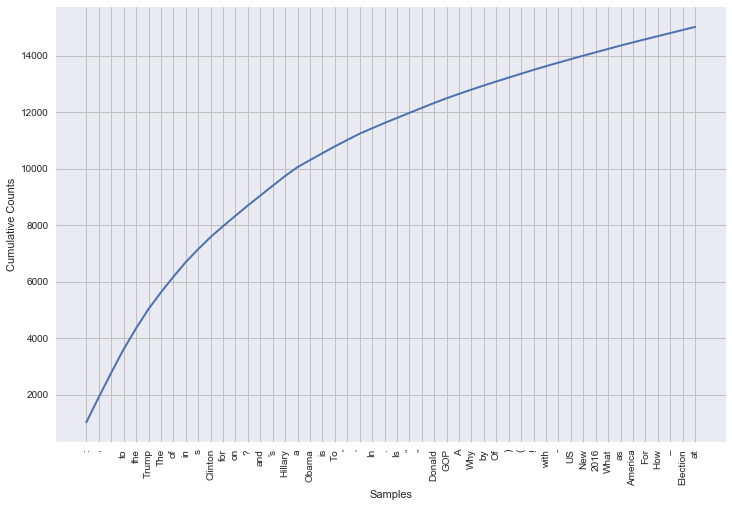

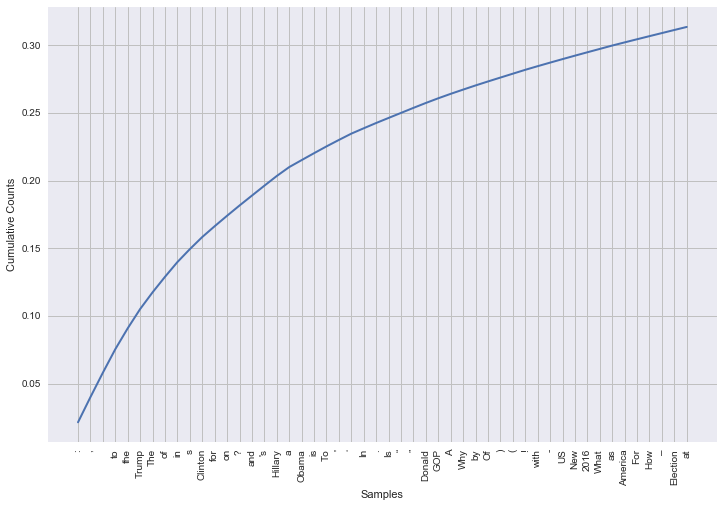

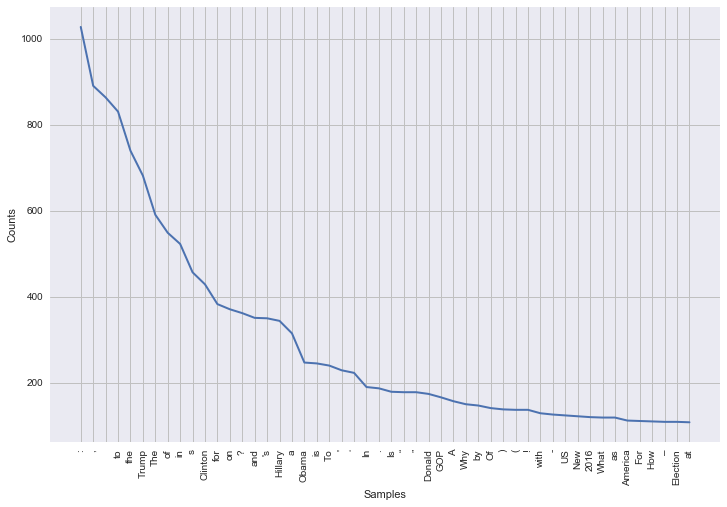

In [19]:
# training title
plot_freq(tokenize_whole(train.title))
plot_freq(tokenize_whole(train.title),prob = True)
plot_freq(tokenize_whole(train.title), cum = False)

We can see that from the cumulative probability distribution, the most common 50 tokens consist about 30% of the whole training title texts. Let's compare it between Fake and Real news.

Fake title


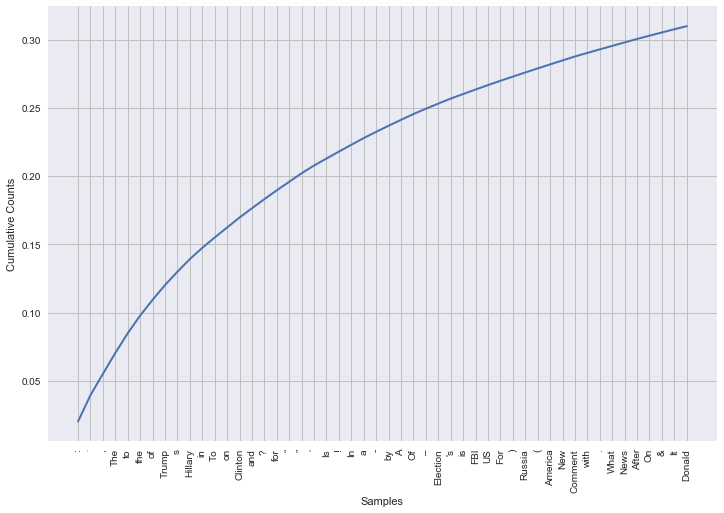


 Real title


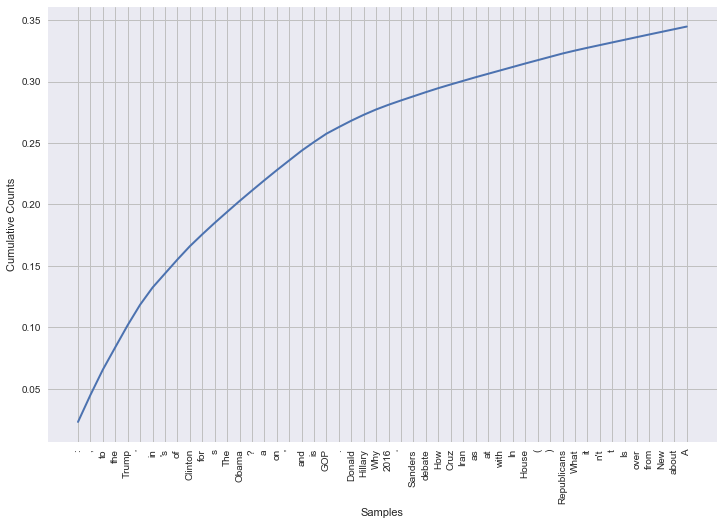

Fake text


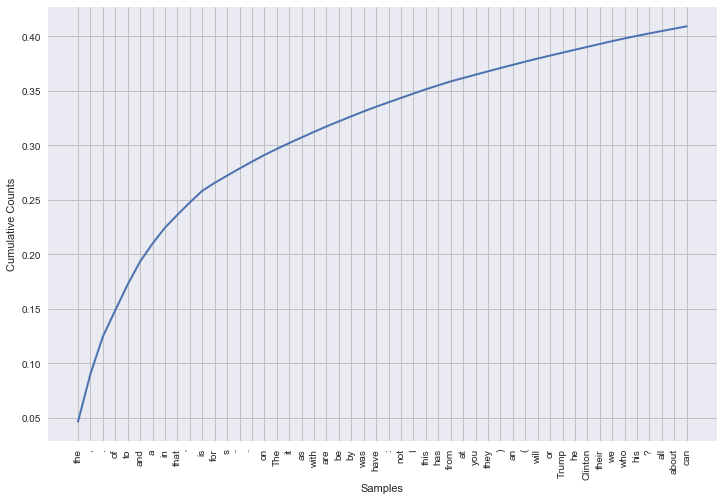


 Real text


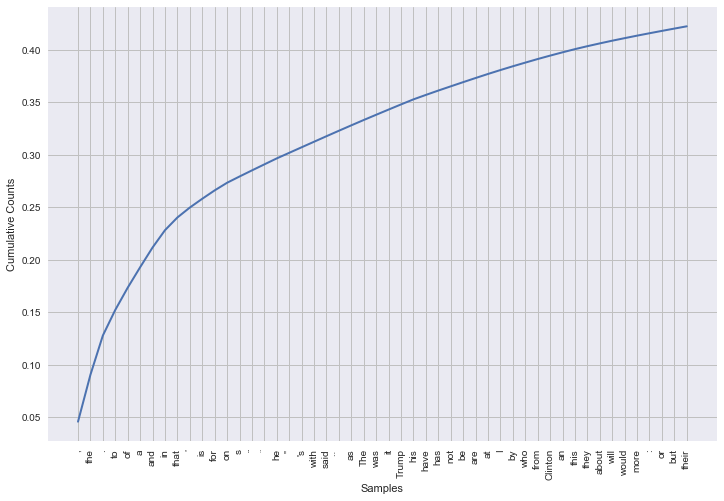

In [20]:
# training title fake vs real
print("Fake title")
plot_freq(tokenize_whole(train[train.label == 'FAKE'].title),prob = True)

print("\n Real title")
plot_freq(tokenize_whole(train[train.label == 'REAL'].title),prob = True)

print("Fake text")
plot_freq(tokenize_whole(train[train.label == 'FAKE'].text),prob = True)

print("\n Real text")
plot_freq(tokenize_whole(train[train.label == 'REAL'].text),prob = True)


As seen, it's hard to distinguish between fake and real text as some words are just used a lot in both texts. We need to construct set of stopwords and also normalize the text to see real differences.

In [21]:
train_text_length = [len(tokenize_normal(i)) for i in train.text]
train_title_length = [len(tokenize_normal(i)) for i in train.title]
test_text_length = [len(tokenize_normal(i)) for i in test.text]
test_title_length = [len(tokenize_normal(i)) for i in test.title]

In [22]:
# index for fake text
train_fake_index = train[train.label == 'FAKE'].index.tolist()
train_real_index = train[train.label == 'REAL'].index.tolist()
train_text_fake_length = [train_text_length[i] for i in train_fake_index]
train_text_real_length = [train_text_length[i] for i in train_real_index]
train_title_fake_length = [train_title_length[i] for i in train_fake_index]
train_title_real_length = [train_title_length[i] for i in train_real_index]


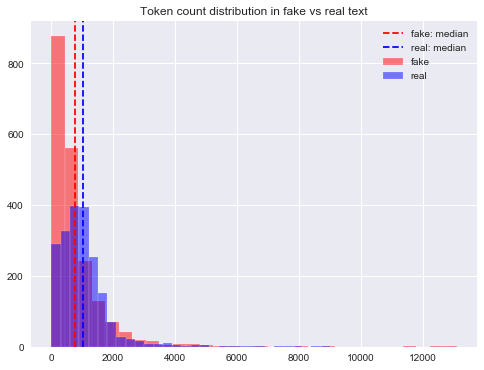

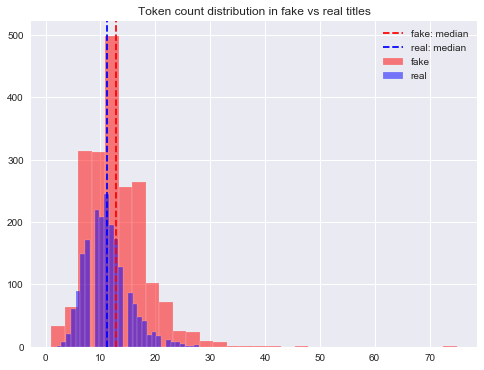

In [23]:
plt.figure(figsize = (8,6))
plt.title("Token count distribution in fake vs real text")
plt.hist(train_text_fake_length, edgecolor = 'white', bins = 30, color = 'red', alpha = 0.5, label = 'fake')
plt.hist(train_text_real_length, edgecolor = 'white', bins = 30, color = 'blue', alpha = 0.5, label = 'real')
plt.axvline(np.mean(train_text_fake_length), color = 'red', linestyle = '--', label = "fake: median")
plt.axvline(np.mean(train_text_real_length), color = 'blue', linestyle = '--', label = "real: median")
plt.legend()
plt.show()

plt.figure(figsize = (8,6))
plt.title("Token count distribution in fake vs real titles")
plt.hist(train_title_fake_length, edgecolor = 'white', bins = 30, color = 'red', alpha = 0.5, label = 'fake')
plt.hist(train_title_real_length, edgecolor = 'white', bins = 30, color = 'blue', alpha = 0.5, label = 'real')
plt.axvline(np.mean(train_title_fake_length), color = 'red', linestyle = '--', label = "fake: median")
plt.axvline(np.mean(train_title_real_length), color = 'blue', linestyle = '--', label = "real: median")
plt.legend()
plt.show()

An interesting thing to note is the distribution of number of tokens used in a text for fake and real texts. The number of words used for each text is smaller in general for fake news than it is for real news. We see that while most of the news are less 500 words for fake news, the distribution is more widely spread for real news.

### Tokenization: standard work_tokenize from nltk with stopwords

In [24]:
# function to tokenize text with stopwords
def tokenize_stopwords(text, stopwords):
    return [t for t in nltk.word_tokenize(text) if t.lower() not in stopwords]

For now, I will use the standard stopwords from the nltk corpus and some punctuations from python's string module.

In [27]:
# define stopwords from nltk.corpus.stopwords.words('english') and string punctuations
import string
stopwords = nltk.corpus.stopwords.words('english') + list(string.punctuation)
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [28]:
# update whole tokenization function to include stopword tokenization
def tokenize_whole(series, stopword_tokenize = False, stopwords=stopwords):
    # tokenize
    if stopword_tokenize:
        tokenized = series.apply(lambda x: tokenize_stopwords(x, stopwords))
    else:
        tokenized = series.apply(lambda x: tokenize_normal(x))
    # group them all into one list
    all_tokens = []
    for i in tokenized:
        all_tokens.extend(i)
    return all_tokens

In [29]:
# test tokenization with stopwords
np.random.seed(42)
top_count(tokenize_stopwords(train.loc[np.random.randint(len(train)),'text'],stopwords))

China appeared 15 times.
’ appeared 9 times.
military appeared 5 times.
sway appeared 4 times.
nation appeared 4 times.
United appeared 3 times.
States appeared 3 times.
Chinese appeared 3 times.
Defense appeared 3 times.
Wanquan appeared 3 times.
world appeared 3 times.
South appeared 3 times.
national appeared 3 times.
security appeared 3 times.
Minister appeared 2 times.
cautioned appeared 2 times.
Russia appeared 2 times.
Australia appeared 2 times.
“ appeared 2 times.
Sea appeared 2 times.


In [33]:
# we see that there are some punctuations not added
# in the standard string.punctuation
# we can remove that by adding new punctuations to the rule
stopwords.extend(['’', '“', '”', '—', "'",'``',"''",'–','…','›'])
#stopwords.remove('?')
#stopwords.remove('!')

In [262]:
# other stopword definition
# fake news may have strong words like 'shouldn't' or 'haven't' and a lot of expressive punctuations like '!' and '?'
# so we do not remove them
stopwords2 = nltk.corpus.stopwords.words('english') 
for i in ['but', 'because', 'until', 'against', 'between', 'again', 'any', 'most', 'few',
                  'only', 'too', 'very', "don't", 'should', "should've", "couldn't",
                  "didn't","doesn't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't",
                  "needn't", "shouldn't", "wasn't", "weren't", "won't", "wouldn't"]:
    stopwords2.remove(i)
punctuations = list(string.punctuation)
punctuations.remove('!')
punctuations.remove('?')
punctuations.extend(['’', '“', '”', '—', "'",'``',"''",'–','…','›'])

remove_2 = stopwords2 + punctuations

## 3-2. Normalization

We can use different stemmers and lemmatiziers to normalize the text data. We also apply POS tagging for lemmatization so that the lemmatization process is more accurate.

In [82]:
# function to normalize text data
# use standard format as porterstemmer

# method names = [ps, ls, ss, wnl]

def normalize_text(text, method, stopwords=stopwords, stop = True, lower = True):
    # tokenize text
    if stop:
        tokens = tokenize_stopwords(text, stopwords)
    else:
        tokens = tokenize_normal(text)
    
    # lowercase
    if lower:
        tokens_l = [t.lower() for t in tokens]
    else:
        tokens_l = tokens
    
    # for all stemming methods
    if method != wnl:
        # stem tokens
        stemmed_tokens = [method.stem(t) for t in tokens_l]
        return stemmed_tokens
    else:
        # lemmatize tokens
        lemmatized_tokens = [method.lemmatize(t) for t in tokens_l]
        return lemmatized_tokens
    
# intialize normalizing methods
ps = nltk.stem.PorterStemmer()
ls = nltk.stem.LancasterStemmer()
ss = nltk.stem.SnowballStemmer('english')
wnl = nltk.stem.WordNetLemmatizer()

In [133]:
# pos tagging for lemmatization
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def penn_to_wn(tag):
    return get_wordnet_pos(tag)

def pos_tagger_lemmatizer(tokenized_text,lemm = wnl):
    tagged = nltk.pos_tag(tokenized_text)
    lem = []
    for word, tag in tagged:
        wntag=get_wordnet_pos(tag)
        if wntag is None:
            l = lemm.lemmatize(word)
        else:
            l = lemm.lemmatize(word,pos=wntag)
        lem.append(l)
    return lem

In [37]:
# normalize training text data stopwords default
train['lemmatized'] = [normalize_text(t, wnl) for t in train.text]
train['stemmed_porter'] = [normalize_text(t, ps) for t in train.text]
train['stemmed_lancaster'] = [normalize_text(t, ls) for t in train.text]
train['stemmed_snowball'] = [normalize_text(t, ss) for t in train.text]

train['lemmatized_sw2'] = [normalize_text(t, wnl,stopwords=  remove_2) for t in train.text]
train['stemmed_porter_sw2'] = [normalize_text(t, ps,stopwords=  remove_2) for t in train.text]
train['stemmed_lancaster_sw2'] = [normalize_text(t, ls,stopwords=  remove_2) for t in train.text]
train['stemmed_snowball_sw2'] = [normalize_text(t, ss,stopwords=  remove_2) for t in train.text]

In [38]:
# normalize training title data
train['lemmatized_title'] = [normalize_text(t, wnl) for t in train.title]
train['stemmed_porter_title'] = [normalize_text(t, ps) for t in train.title]
train['stemmed_lancaster_title'] = [normalize_text(t, ls) for t in train.title]
train['stemmed_snowball_title'] = [normalize_text(t, ss) for t in train.title]

train['lemmatized_title_sw2'] = [normalize_text(t, wnl,stopwords=  remove_2) for t in train.title]
train['stemmed_porter_title_sw2'] = [normalize_text(t, ps,stopwords=  remove_2) for t in train.title]
train['stemmed_lancaster_title_sw2'] = [normalize_text(t, ls,stopwords=  remove_2) for t in train.title]
train['stemmed_snowball_title_sw2'] = [normalize_text(t, ss,stopwords=  remove_2) for t in train.title]


In [39]:
# normalize test text data
test['lemmatized'] = [normalize_text(t, wnl) for t in test.text]
test['stemmed_porter'] = [normalize_text(t, ps) for t in test.text]
test['stemmed_lancaster'] = [normalize_text(t, ls) for t in test.text]
test['stemmed_snowball'] = [normalize_text(t, ss) for t in test.text]

test['lemmatized_sw2'] = [normalize_text(t, wnl, stopwords = remove_2) for t in test.text]
test['stemmed_porter_sw2'] = [normalize_text(t, ps, stopwords = remove_2) for t in test.text]
test['stemmed_lancaster_sw2'] = [normalize_text(t, ls, stopwords = remove_2) for t in test.text]
test['stemmed_snowball_sw2'] = [normalize_text(t, ss, stopwords = remove_2) for t in test.text]


In [40]:
# normalize test title data
test['lemmatized_title'] = [normalize_text(t, wnl) for t in test.title]
test['stemmed_porter_title'] = [normalize_text(t, ps) for t in test.title]
test['stemmed_lancaster_title'] = [normalize_text(t, ls) for t in test.title]
test['stemmed_snowball_title'] = [normalize_text(t, ss) for t in test.title]

test['lemmatized_title_sw2'] = [normalize_text(t, wnl, stopwords = remove_2) for t in test.title]
test['stemmed_porter_title_sw2'] = [normalize_text(t, ps, stopwords = remove_2) for t in test.title]
test['stemmed_lancaster_title_sw2'] = [normalize_text(t, ls, stopwords = remove_2) for t in test.title]
test['stemmed_snowball_title_sw2'] = [normalize_text(t, ss, stopwords = remove_2) for t in test.title]


In [137]:
# lemmatizier with pos tag
train['lemmatized_pos'] = [pos_tagger_lemmatizer(t2) for t2 in [tokenize_stopwords(t,stopwords) for t in train.text]]
train['lemmatized_pos_title'] = [pos_tagger_lemmatizer(t2) for t2 in [tokenize_stopwords(t,stopwords) for t in train.title]]
test['lemmatized_pos'] = [pos_tagger_lemmatizer(t2) for t2 in [tokenize_stopwords(t,stopwords) for t in test.text]]
test['lemmatized_pos_title'] = [pos_tagger_lemmatizer(t2) for t2 in [tokenize_stopwords(t,stopwords) for t in test.title]]

train['lemmatized_pos_sw2'] = [pos_tagger_lemmatizer(t2) for t2 in [tokenize_stopwords(t,remove_2) for t in train.text]]
train['lemmatized_pos_title_sw2'] = [pos_tagger_lemmatizer(t2) for t2 in [tokenize_stopwords(t,remove_2) for t in train.title]]
test['lemmatized_pos_sw2'] = [pos_tagger_lemmatizer(t2) for t2 in [tokenize_stopwords(t,remove_2) for t in test.text]]
test['lemmatized_pos_title_sw2'] = [pos_tagger_lemmatizer(t2) for t2 in [tokenize_stopwords(t,remove_2) for t in test.title]]

In [138]:
# export current dataframe as intermediary csv files
#train.to_csv("train_tokandstem.csv")
#test.to_csv("test_tokandstem.csv")

In [263]:
# view training data
train.head(2)

,ID,title,text,label,lemmatized,stemmed_porter,stemmed_lancaster,stemmed_snowball,lemmatized_sw2,stemmed_porter_sw2,stemmed_lancaster_sw2,stemmed_snowball_sw2,lemmatized_title,stemmed_porter_title,stemmed_lancaster_title,stemmed_snowball_title,lemmatized_title_sw2,stemmed_porter_title_sw2,stemmed_lancaster_title_sw2,stemmed_snowball_title_sw2,lemmatized_pos,lemmatized_pos_title,lemmatized_pos_sw2,lemmatized_pos_title_sw2
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,"[daniel, greenfield, shillman, journalism, fel...","[daniel, greenfield, shillman, journal, fellow...","[daniel, greenfield, shillm, journ, fellow, fr...","[daniel, greenfield, shillman, journal, fellow...","[daniel, greenfield, shillman, journalism, fel...","[daniel, greenfield, shillman, journal, fellow...","[daniel, greenfield, shillm, journ, fellow, fr...","[daniel, greenfield, shillman, journal, fellow...","[smell, hillary, fear]","[smell, hillari, fear]","[smel, hil, fear]","[smell, hillari, fear]","[smell, hillary, fear]","[smell, hillari, fear]","[smel, hil, fear]","[smell, hillari, fear]","[Daniel, Greenfield, Shillman, Journalism, Fel...","[Smell, Hillary, Fear]","[Daniel, Greenfield, Shillman, Journalism, Fel...","[Smell, Hillary, Fear]"
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,"[google, pinterest, digg, linkedin, reddit, st...","[googl, pinterest, digg, linkedin, reddit, stu...","[googl, pinterest, dig, linkedin, reddit, stum...","[googl, pinterest, digg, linkedin, reddit, stu...","[google, pinterest, digg, linkedin, reddit, st...","[googl, pinterest, digg, linkedin, reddit, stu...","[googl, pinterest, dig, linkedin, reddit, stum...","[googl, pinterest, digg, linkedin, reddit, stu...","[watch, exact, moment, paul, ryan, committed, ...","[watch, exact, moment, paul, ryan, commit, pol...","[watch, exact, mom, paul, ryan, commit, polit,...","[watch, exact, moment, paul, ryan, commit, pol...","[watch, exact, moment, paul, ryan, committed, ...","[watch, exact, moment, paul, ryan, commit, pol...","[watch, exact, mom, paul, ryan, commit, polit,...","[watch, exact, moment, paul, ryan, commit, pol...","[Google, Pinterest, Digg, Linkedin, Reddit, St...","[Watch, Exact, Moment, Paul, Ryan, Committed, ...","[Google, Pinterest, Digg, Linkedin, Reddit, St...","[Watch, Exact, Moment, Paul, Ryan, Committed, ..."


In [264]:
# view test data
test.head(2)

,ID,title,text,lemmatized,stemmed_porter,stemmed_lancaster,stemmed_snowball,lemmatized_sw2,stemmed_porter_sw2,stemmed_lancaster_sw2,stemmed_snowball_sw2,lemmatized_title,stemmed_porter_title,stemmed_lancaster_title,stemmed_snowball_title,lemmatized_title_sw2,stemmed_porter_title_sw2,stemmed_lancaster_title_sw2,stemmed_snowball_title_sw2,lemmatized_pos,lemmatized_pos_title,lemmatized_pos_sw2,lemmatized_pos_title_sw2
0,10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...,"[september, new, home, sale, rise, back, 1992,...","[septemb, new, home, sale, rise, back, 1992, l...","[septemb, new, hom, sal, ris, back, 1992, leve...","[septemb, new, home, sale, rise, back, 1992, l...","[september, new, home, sale, rise, back, 1992,...","[septemb, new, home, sale, rise, back, 1992, l...","[septemb, new, hom, sal, ris, back, 1992, leve...","[septemb, new, home, sale, rise, back, 1992, l...","[september, new, home, sale, rise——-back, 1992...","[septemb, new, home, sale, rise——-back, 1992, ...","[septemb, new, hom, sal, rise——-back, 1992, le...","[septemb, new, home, sale, rise——-back, 1992, ...","[september, new, home, sale, rise——-back, 1992...","[septemb, new, home, sale, rise——-back, 1992, ...","[septemb, new, hom, sal, rise——-back, 1992, le...","[septemb, new, home, sale, rise——-back, 1992, ...","[September, New, Homes, Sales, Rise, Back, 199...","[September, New, Homes, Sales, Rise——-Back, 19...","[September, New, Homes, Sales, Rise, Back, 199...","[September, New, Homes, Sales, Rise——-Back, 19..."
1,2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...,"[congress, debated, passed, patient, protectio...","[congress, debat, pass, patient, protect, affo...","[congress, deb, pass, paty, protect, afford, c...","[congress, debat, pass, patient, protect, affo...","[but, congress, debated, passed, patient, prot...","[but, congress, debat, pass, patient, protect,...","[but, congress, deb, pass, paty, protect, affo...","[but, congress, debat, pass, patient, protect,...","[obamacare, doomsday, cult, ca, n't, admit, 's...","[obamacar, doomsday, cult, ca, n't, admit, 's,...","[obamac, doomsday, cult, ca, n't, admit, 's, w...","[obamacar, doomsday, cult, ca, n't, admit, 's,...","[obamacare, doomsday, cult, ca, n't, admit, 's...","[obamacar, doomsday, cult, ca, n't, admit, 's,...","[obamac, doomsday, cult, ca, n't, admit, 's, w...","[obamacar, doomsday, cult, ca, n't, admit, 's,...","[Congress, debate, pass, Patient, Protection, ...","[Obamacare, Doomsday, Cult, Ca, n't, Admit, 's...","[But, Congress, debate, pass, Patient, Protect...","[Obamacare, Doomsday, Cult, Ca, n't, Admit, 's..."


Let's look at the common words now that the stopwords are removed, and texts have been normalized.

In [44]:
def series_to_single_list(tokenized_series):
    all_list = []
    for i in tokenized_series:
        all_list.extend(i)
    return all_list

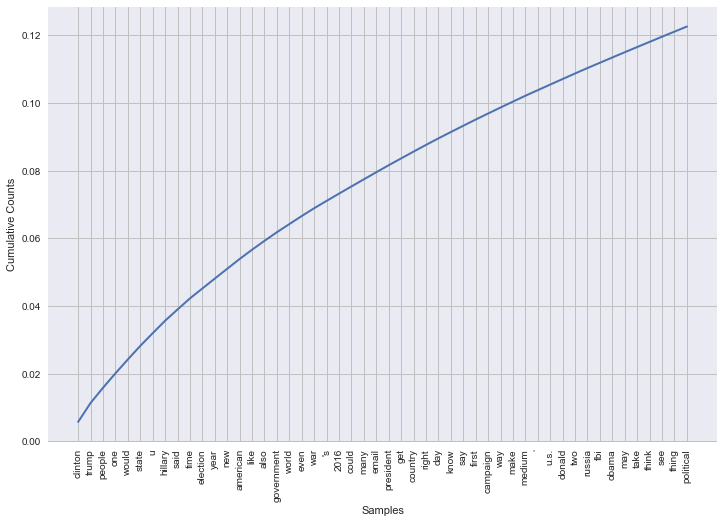

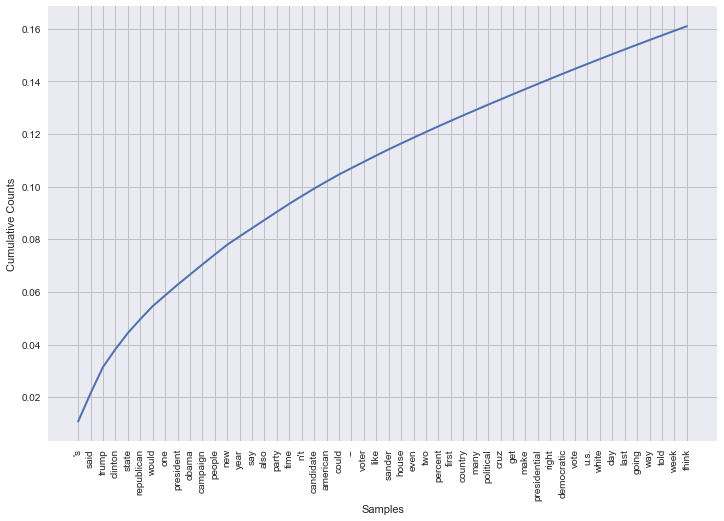

In [45]:
plot_freq(series_to_single_list(train[train.label == 'FAKE'].lemmatized),prob = True)
plot_freq(series_to_single_list(train[train.label == 'REAL'].lemmatized),prob = True)

## 3-3. Visualizing common words: Word Cloud

Let's compare the top most occuring words by 'FAKE' and 'REAL' labels. We can visualize this by using the wordcloud.

In [50]:
# import library
from wordcloud import WordCloud

In [51]:
# function to create wordcloud
def create_wordcloud(token_list, max_words = 100):
    # initiate wordcloud
    wc = WordCloud(max_words = max_words)
    # generate wordcloud with string of all tokens
    wc.generate_from_text(' '.join(token_list))
    # produce output
    plt.figure(figsize = (12,12))
    plt.imshow(wc)
    plt.axis('off')
    return plt.show()

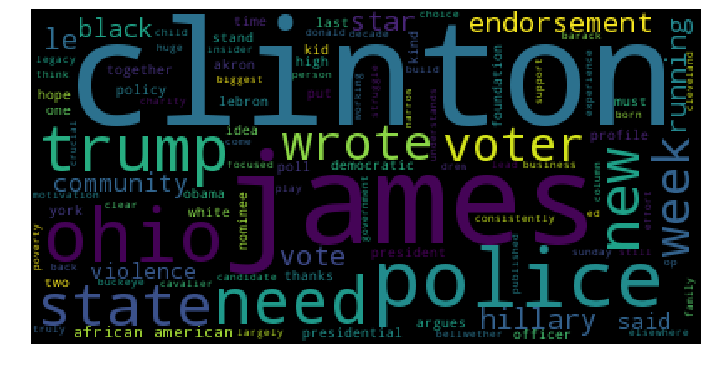

In [291]:
# wordcloud for single lemmatized training text for an example
create_wordcloud(train.loc[np.random.randint(len(train)), 'lemmatized'])

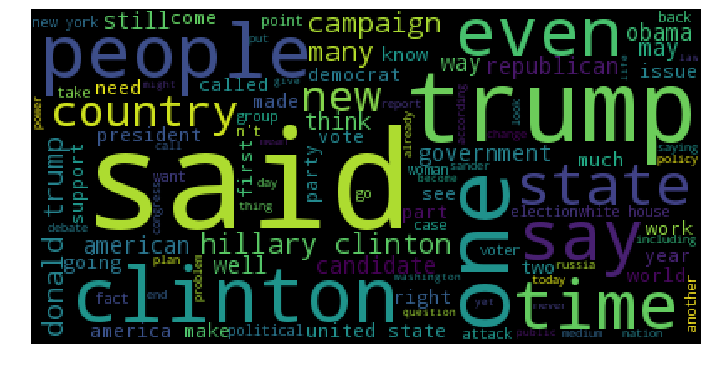

In [315]:
# wordcloud for whole lemmatized data
total_lem = []
for i in train.lemmatized:
    total_lem.extend(i)
    
create_wordcloud(total_lem)

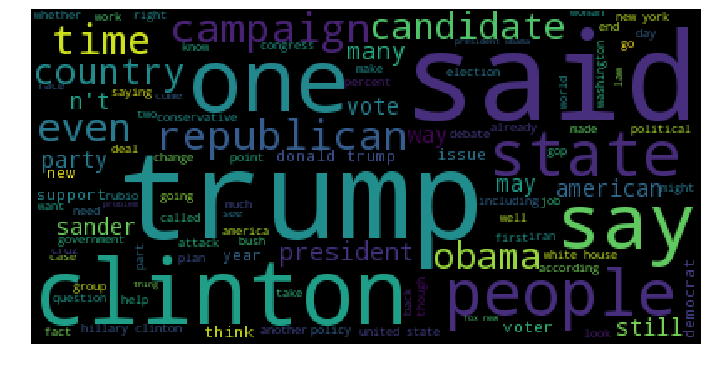

In [317]:
# wordcloud for lemmatized text for only REAL documents
real_lem = []
for i in train[train.label == 'REAL'].lemmatized:
    real_lem.extend(i)
    
create_wordcloud(real_lem)

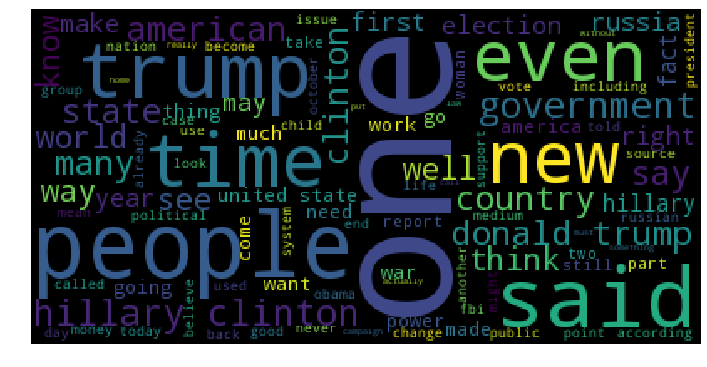

In [318]:
# wordcloud for lemmatized text for only FAKE documents
fake_lem = []
for i in train[train.label == 'FAKE'].lemmatized:
    fake_lem.extend(i)
    
create_wordcloud(fake_lem)

# 4. Modeling: Text Classifier

In [64]:
# concat title and text
def list_to_str(lists):
    for i in range(len(lists)):
        lists[i] = " ".join(lists[i])
    return lists

train_lem = train.lemmatized_title + train.lemmatized
train_lem = list_to_str(train_lem)
test_lem = test.lemmatized_title + test.lemmatized
test_lem = list_to_str(test_lem)
train_lem_sw2 = train.lemmatized_title_sw2 + train.lemmatized_sw2
train_lem_sw2 = list_to_str(train_lem_sw2)
test_lem_sw2 = test.lemmatized_title_sw2 + test.lemmatized_sw2
test_lem_sw2 = list_to_str(test_lem_sw2)

train_ps = train.stemmed_porter_title + train.stemmed_porter
train_ps = list_to_str(train_ps)
test_ps = test.stemmed_porter_title + test.stemmed_porter
test_ps = list_to_str(test_ps)
train_ps_sw2 = train.stemmed_porter_title_sw2 + train.stemmed_porter_sw2
train_ps_sw2 = list_to_str(train_ps_sw2)
test_ps_sw2 = test.stemmed_porter_title_sw2 + test.stemmed_porter_sw2
test_ps_sw2 = list_to_str(test_ps_sw2)

train_ls = train.stemmed_lancaster_title + train.stemmed_lancaster
train_ls = list_to_str(train_ls)
test_ls = test.stemmed_lancaster_title + test.stemmed_lancaster
test_ls = list_to_str(test_ls)
train_ls_sw2 = train.stemmed_lancaster_title_sw2 + train.stemmed_lancaster_sw2
train_ls_sw2 = list_to_str(train_ls_sw2)
test_ls_sw2 = test.stemmed_lancaster_title_sw2 + test.stemmed_lancaster_sw2
test_ls_sw2 = list_to_str(test_ls_sw2)

train_ss = train.stemmed_snowball_title + train.stemmed_snowball
train_ss = list_to_str(train_ss)
test_ss = test.stemmed_snowball_title + test.stemmed_snowball
test_ss = list_to_str(test_ss)
train_ss_sw2 = train.stemmed_snowball_title_sw2 + train.stemmed_snowball_sw2
train_ss_sw2 = list_to_str(train_ss_sw2)
test_ss_sw2 = test.stemmed_snowball_title_sw2 + test.stemmed_snowball_sw2
test_ss_sw2 = list_to_str(test_ss_sw2)

train_lem_pos = train.lemmatized_pos_title + train.lemmatized_pos
train_lem_pos = list_to_str(train_lem_pos)
test_lem_pos = test.lemmatized_pos_title + test.lemmatized_pos
test_lem_pos = list_to_str(test_lem_pos)
train_lem_pos_sw2 = train.lemmatized_pos_title_sw2 + train.lemmatized_pos_sw2
train_lem_pos_sw2 = list_to_str(train_lem_pos_sw2)
test_lem_pos_sw2 = test.lemmatized_pos_title_sw2 + test.lemmatized_pos_sw2
test_lem_pos_sw2 = list_to_str(test_lem_pos_sw2)

y = train.label.replace({'FAKE':0,'REAL':1})

In [59]:
# classifiers
from sklearn.naive_bayes import MultinomialNB
from nltk.classify import NaiveBayesClassifier
from sklearn.linear_model import LogisticRegression
from nltk.classify import MaxentClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

# vectorizer using tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

# initialize basic classifsiers
mnb = MultinomialNB()
#nb = NaiveBayesClassifier()
lr = LogisticRegression()
#me = MaxentClassifier()
svc = LinearSVC()
pa = PassiveAggressiveClassifier()
sgd = SGDClassifier()

In [60]:
# function to create a model based on pipeline
def classification_pipeline(classifier):
    model = Pipeline([
        ('vectorizer', TfidfVectorizer(
        tokenizer = None, preprocessor = None, lowercase = False)),
        ('classifier', classifier)
    ])
    return model

In [63]:
# store mean cv score for each combination in a dataframe
scores = pd.DataFrame()
classification = [mnb, lr, svc, pa, sgd]
classification_str = ['mnb', 'lr', 'svc', 'pa', 'sgd']
text_type = [train_lem, train_ps, train_ls, train_ss, train_lem_pos]
text_type_str = ['train_lem', 'train_ps', 'train_ls', 'train_ss', 'train_lem_pos']
count = 0
for c in range(len(classification)):
    clf = classification[c]
    for t in range(len(text_type)):
        text = text_type[t]
        s = cross_val_score(classification_pipeline(clf),
                           text, y, cv = 10,
                           scoring = 'f1', verbose = 5)
        scores.loc[count,'method'] = classification_str[c] + '_' + text_type_str[t]
        scores.loc[count,'cv_score'] = s.mean()
        count = count+1

[CV]  ................................................................
[CV] ....................... , score=0.8583877995642701, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] ....................... , score=0.8466522678185745, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s


[CV] ....................... , score=0.8389830508474575, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.0s remaining:    0.0s


[CV] ....................... , score=0.8425531914893616, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.7s remaining:    0.0s


[CV] ....................... , score=0.8333333333333333, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.8577680525164114, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.8682505399568033, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.8280254777070063, total=   1.9s
[CV]  ................................................................
[CV] ....................... , score=0.8441558441558441, total=   1.8s
[CV]  ................................................................
[CV] ....................... , score=0.8382978723404255, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.4s finished


[CV] ....................... , score=0.8615384615384616, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] ........................ , score=0.843010752688172, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s


[CV] ....................... , score=0.8389830508474575, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.0s remaining:    0.0s


[CV] ....................... , score=0.8425531914893616, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.8s remaining:    0.0s


[CV] ........................ , score=0.840085287846482, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.8615384615384616, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.8701298701298702, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.8305084745762711, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.8434782608695651, total=   1.8s
[CV]  ................................................................
[CV] ....................... , score=0.8412017167381973, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.2s finished


[CV] ....................... , score=0.8646288209606987, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] ....................... , score=0.8382978723404254, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s


[CV] ....................... , score=0.8354430379746836, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.0s remaining:    0.0s


[CV] ....................... , score=0.8407643312101911, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.7s remaining:    0.0s


[CV] ....................... , score=0.8369098712446352, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.8540305010893247, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.8676789587852495, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.8252631578947369, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.8398268398268398, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.8347457627118644, total=   1.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.3s finished


[CV] ....................... , score=0.8552631578947368, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] ........................ , score=0.843010752688172, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s


[CV] ....................... , score=0.8372093023255813, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.8s remaining:    0.0s


[CV] ....................... , score=0.8425531914893616, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.5s remaining:    0.0s


[CV] ....................... , score=0.8365180467091295, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.8634361233480177, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.8645161290322582, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.8305084745762711, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.8453159041394335, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.8412017167381973, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.8s finished


[CV] ....................... , score=0.9122807017543859, total=   2.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV] ....................... , score=0.8976377952755905, total=   2.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s


[CV] ....................... , score=0.9160305343511451, total=   2.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.2s remaining:    0.0s


[CV] ....................... , score=0.9123711340206185, total=   2.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.3s remaining:    0.0s


[CV] ....................... , score=0.8900523560209426, total=   2.0s
[CV]  ................................................................
[CV] ....................... , score=0.9086161879895561, total=   2.0s
[CV]  ................................................................
[CV] ..................................... , score=0.94, total=   2.1s
[CV]  ................................................................
[CV] ....................... , score=0.8860103626943006, total=   2.1s
[CV]  ................................................................
[CV] ....................... , score=0.8997429305912596, total=   2.0s
[CV]  ................................................................
[CV] ....................... , score=0.9076923076923077, total=   2.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   20.6s finished


[CV] ....................... , score=0.9118387909319899, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] ....................... , score=0.9028871391076116, total=   1.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s


[CV] ....................... , score=0.9104859335038363, total=   1.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.6s remaining:    0.0s


[CV] ........................ , score=0.902061855670103, total=   1.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.5s remaining:    0.0s


[CV] ....................... , score=0.8923884514435695, total=   1.9s
[CV]  ................................................................
[CV] ....................... , score=0.9062499999999999, total=   1.9s
[CV]  ................................................................
[CV] ........................ , score=0.942643391521197, total=   1.8s
[CV]  ................................................................
[CV] ....................... , score=0.8979591836734694, total=   1.9s
[CV]  ................................................................
[CV] ........................ , score=0.900763358778626, total=   1.9s
[CV]  ................................................................
[CV] ....................... , score=0.9081632653061226, total=   1.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.7s finished


[CV] ....................... , score=0.9168765743073048, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] ....................... , score=0.9005235602094241, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s


[CV] ....................... , score=0.9002557544757034, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.5s remaining:    0.0s


[CV] ....................... , score=0.9072164948453608, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.3s remaining:    0.0s


[CV] ....................... , score=0.8997429305912596, total=   1.8s
[CV]  ................................................................
[CV] ....................... , score=0.9062499999999999, total=   1.8s
[CV]  ................................................................
[CV] ..................................... , score=0.95, total=   1.8s
[CV]  ................................................................
[CV] ....................... , score=0.8928571428571429, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.8956743002544529, total=   1.8s
[CV]  ................................................................
[CV] ....................... , score=0.9043927648578811, total=   1.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.3s finished


[CV] ....................... , score=0.9145728643216081, total=   1.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] ....................... , score=0.9028871391076116, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s


[CV] ....................... , score=0.9048843187660668, total=   1.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.7s remaining:    0.0s


[CV] ....................... , score=0.8992248062015503, total=   1.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.6s remaining:    0.0s


[CV] ....................... , score=0.8923884514435695, total=   2.0s
[CV]  ................................................................
[CV] ....................... , score=0.9086161879895561, total=   1.9s
[CV]  ................................................................
[CV] ....................... , score=0.9476309226932668, total=   1.9s
[CV]  ................................................................
[CV] ....................... , score=0.8923076923076922, total=   1.9s
[CV]  ................................................................
[CV] ........................ , score=0.900763358778626, total=   1.9s
[CV]  ................................................................
[CV] ....................... , score=0.9081632653061226, total=   1.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   19.0s finished


[CV] ........................ , score=0.912718204488778, total=   1.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] ........................ , score=0.930232558139535, total=   1.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s


[CV] ....................... , score=0.9305912596401028, total=   1.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.8s remaining:    0.0s


[CV] ....................... , score=0.9292929292929293, total=   1.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.7s remaining:    0.0s


[CV] ........................ , score=0.930232558139535, total=   1.8s
[CV]  ................................................................
[CV] ....................... , score=0.9309462915601023, total=   1.9s
[CV]  ................................................................
[CV] ..................................... , score=0.96, total=   2.0s
[CV]  ................................................................
[CV] ....................... , score=0.9242424242424243, total=   2.0s
[CV]  ................................................................
[CV] ....................... , score=0.9172932330827068, total=   2.0s
[CV]  ................................................................
[CV] ....................... , score=0.9393939393939393, total=   2.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   19.4s finished


[CV] ....................... , score=0.9323308270676692, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] ....................... , score=0.9408740359897172, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s


[CV] ....................... , score=0.9363867684478373, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.5s remaining:    0.0s


[CV] ....................... , score=0.9326683291770573, total=   1.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.3s remaining:    0.0s


[CV] ........................ , score=0.930232558139535, total=   1.8s
[CV]  ................................................................
[CV] ....................... , score=0.9258312020460358, total=   1.8s
[CV]  ................................................................
[CV] ....................... , score=0.9502487562189055, total=   1.8s
[CV]  ................................................................
[CV] ....................... , score=0.9246231155778896, total=   1.8s
[CV]  ................................................................
[CV] ....................... , score=0.9223057644110277, total=   1.8s
[CV]  ................................................................
[CV] ....................... , score=0.9343434343434343, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.2s finished


[CV] ....................... , score=0.9319899244332494, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] ....................... , score=0.9246753246753247, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s


[CV] ....................... , score=0.9340101522842639, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.3s remaining:    0.0s


[CV] ....................... , score=0.9402985074626865, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.0s remaining:    0.0s


[CV] ....................... , score=0.9203084832904884, total=   1.7s
[CV]  ................................................................
[CV] ........................ , score=0.923076923076923, total=   1.8s
[CV]  ................................................................
[CV] ..................................... , score=0.95, total=   1.8s
[CV]  ................................................................
[CV] ....................... , score=0.9191919191919192, total=   1.9s
[CV]  ................................................................
[CV] ....................... , score=0.9118387909319899, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9226932668329176, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.6s finished


[CV] ....................... , score=0.9323308270676692, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] ....................... , score=0.9405684754521964, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s


[CV] ....................... , score=0.9390862944162437, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.4s remaining:    0.0s


[CV] ..................................... , score=0.93, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.1s remaining:    0.0s


[CV] ........................ , score=0.927461139896373, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9258312020460358, total=   1.8s
[CV]  ................................................................
[CV] ....................... , score=0.9502487562189055, total=   1.8s
[CV]  ................................................................
[CV] ....................... , score=0.9246231155778896, total=   1.8s
[CV]  ................................................................
[CV] ....................... , score=0.9195979899497487, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9343434343434343, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.7s finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9303482587064678, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s


[CV] ....................... , score=0.9282051282051281, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9323308270676692, total=   1.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.4s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9230769230769231, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.3s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9343434343434343, total=   1.8s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9238578680203046, total=   1.8s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9528535980148882, total=   1.8s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9195979899497488, total=   1.8s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9234567901234569, total=   1.8s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.2s finished


[CV] ..................................... , score=0.94, total=   1.8s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9303482587064678, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s


[CV] ....................... , score=0.9336734693877551, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.1s remaining:    0.0s


[CV] ....................... , score=0.9203980099502488, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.7s remaining:    0.0s


[CV] ....................... , score=0.9162561576354681, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9289340101522843, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9191919191919192, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9473684210526316, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9226932668329176, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9135802469135802, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.7s finished


[CV] ....................... , score=0.9276807980049875, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9356435643564357, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s


[CV] ........................ , score=0.921119592875318, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.0s remaining:    0.0s


[CV] ....................... , score=0.9346733668341709, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.7s remaining:    0.0s


[CV] ....................... , score=0.9181141439205955, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........................ , score=0.921119592875318, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9195979899497488, total=   1.5s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9552238805970149, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9269521410579346, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9113300492610837, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.5s finished


[CV] ....................... , score=0.9135802469135802, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9280397022332506, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s


[CV] ....................... , score=0.9333333333333332, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.3s remaining:    0.0s


[CV] .................................... , score=0.925, total=   1.8s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9162561576354681, total=   1.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.2s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9156010230179028, total=   1.8s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9238578680203046, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9523809523809523, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9226932668329176, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9145728643216081, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.1s finished


[CV] ....................... , score=0.9280397022332506, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9253731343283582, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s


[CV] ....................... , score=0.9218749999999999, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.2s remaining:    0.0s


[CV] ....................... , score=0.9269521410579346, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.9s remaining:    0.0s


[CV] ....................... , score=0.9280397022332506, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........................ , score=0.930232558139535, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9215189873417722, total=   1.8s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9601990049751243, total=   1.8s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9296482412060302, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9118387909319899, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.3s finished


[CV] ....................... , score=0.9319899244332494, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] ....................... , score=0.9276807980049875, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s


[CV] ........................ , score=0.935064935064935, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.8s remaining:    0.0s


[CV] ....................... , score=0.9296482412060302, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.4s remaining:    0.0s


[CV] ....................... , score=0.9268292682926829, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......................... , score=0.93573264781491, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9151670951156812, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9468354430379746, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9223057644110275, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9223057644110277, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.0s finished


[CV] ....................... , score=0.9257425742574258, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] ....................... , score=0.9257425742574258, total=   1.5s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s


[CV] ....................... , score=0.9289340101522843, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.6s remaining:    0.0s


[CV] ....................... , score=0.9285714285714286, total=   1.5s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.2s remaining:    0.0s


[CV] ....................... , score=0.9261083743842363, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9156010230179028, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9242424242424243, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9526184538653366, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9207920792079208, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9145728643216081, total=   1.5s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.5s finished


[CV] ..................................... , score=0.92, total=   1.5s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] ....................... , score=0.9273182957393483, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s


[CV] ....................... , score=0.9340101522842639, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.7s remaining:    0.0s


[CV] ....................... , score=0.9195979899497488, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.3s remaining:    0.0s


[CV] ....................... , score=0.9090909090909091, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9387755102040817, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9207161125319693, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........................ , score=0.945273631840796, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9330024813895781, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ..................................... , score=0.93, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.9319899244332494, total=   1.6s


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.8s finished


In [65]:
# store mean cv score for each combination in a dataframe
scores2 = pd.DataFrame()
classification = [mnb, lr, svc, pa, sgd]
classification_str = ['mnb', 'lr', 'svc', 'pa', 'sgd']
text_type = [train_lem_sw2, train_ps_sw2, train_ls_sw2, train_ss_sw2, train_lem_pos_sw2]
text_type_str = ['train_lem_sw2', 'train_ps_sw2', 'train_ls_sw2', 'train_ss_sw2', 'train_lem_pos_sw2']
count = 0
for c in range(len(classification)):
    clf = classification[c]
    for t in range(len(text_type)):
        text = text_type[t]
        s = cross_val_score(classification_pipeline(clf),
                           text, y, cv = 10,
                           scoring = 'f1', verbose = 5)
        scores2.loc[count,'method'] = classification_str[c] + '_' + text_type_str[t]
        scores2.loc[count,'cv_score'] = s.mean()
        count = count+1

[CV]  ................................................................
[CV] ....................... , score=0.8602620087336246, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] ....................... , score=0.8412017167381974, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s


[CV] ....................... , score=0.8372093023255813, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.2s remaining:    0.0s


[CV] ....................... , score=0.8389830508474575, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.9s remaining:    0.0s


[CV] ........................ , score=0.835117773019272, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.8540305010893247, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.8682505399568033, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.8287526427061309, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.8387096774193549, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.8365180467091295, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.1s finished


[CV] ....................... , score=0.8665207877461706, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] ........................ , score=0.843010752688172, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s


[CV] ....................... , score=0.8389830508474575, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.8s remaining:    0.0s


[CV] ....................... , score=0.8354430379746836, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.4s remaining:    0.0s


[CV] ....................... , score=0.8382978723404254, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.8558951965065502, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.8663793103448276, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.8305084745762711, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.8416485900216919, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.8412017167381973, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.9s finished


[CV] ....................... , score=0.8671023965141613, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] ....................... , score=0.8365180467091295, total=   1.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s


[CV] ....................... , score=0.8354430379746836, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.7s remaining:    0.0s


[CV] ....................... , score=0.8407643312101911, total=   1.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.2s remaining:    0.0s


[CV] ........................ , score=0.835117773019272, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.8540305010893247, total=   1.5s
[CV]  ................................................................
[CV] ....................... , score=0.8695652173913043, total=   1.5s
[CV]  ................................................................
[CV] ....................... , score=0.8277310924369747, total=   1.5s
[CV]  ................................................................
[CV] ....................... , score=0.8380129589632829, total=   1.5s
[CV]  ................................................................
[CV] ....................... , score=0.8312236286919832, total=   1.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.4s finished


[CV] ....................... , score=0.8577680525164114, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] ........................ , score=0.843010752688172, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s


[CV] ....................... , score=0.8372093023255813, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.8s remaining:    0.0s


[CV] ....................... , score=0.8354430379746836, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.5s remaining:    0.0s


[CV] ....................... , score=0.8340425531914893, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.8577680525164114, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.8645161290322582, total=   1.6s
[CV]  ................................................................
[CV] ........................ , score=0.832271762208068, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.8398268398268398, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.8436830835117772, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.9s finished


[CV] ....................... , score=0.9122807017543859, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] ....................... , score=0.8952879581151834, total=   1.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s


[CV] ....................... , score=0.9187817258883249, total=   1.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.6s remaining:    0.0s


[CV] ....................... , score=0.9043927648578812, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.4s remaining:    0.0s


[CV] ....................... , score=0.8900523560209426, total=   1.9s
[CV]  ................................................................
[CV] ....................... , score=0.9033942558746736, total=   1.8s
[CV]  ................................................................
[CV] ....................... , score=0.9450000000000001, total=   1.8s
[CV]  ................................................................
[CV] ....................... , score=0.8831168831168832, total=   1.8s
[CV]  ................................................................
[CV] ....................... , score=0.8969072164948454, total=   1.8s
[CV]  ................................................................
[CV] ....................... , score=0.9076923076923077, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.5s finished


[CV] ....................... , score=0.9118387909319899, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] ....................... , score=0.9005235602094241, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s


[CV] ........................ , score=0.913265306122449, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.2s remaining:    0.0s


[CV] ....................... , score=0.9095607235142119, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.0s remaining:    0.0s


[CV] ....................... , score=0.8906250000000001, total=   1.8s
[CV]  ................................................................
[CV] ........................ , score=0.905759162303665, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9502487562189055, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9002557544757034, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9063291139240507, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9104859335038362, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.5s finished


[CV] ....................... , score=0.9242424242424243, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] ........................ , score=0.905759162303665, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s


[CV] ....................... , score=0.9081632653061225, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.0s remaining:    0.0s


[CV] ....................... , score=0.9072164948453608, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.7s remaining:    0.0s


[CV] ........................ , score=0.902061855670103, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9090909090909092, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9526184538653366, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.8900255754475703, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.8962025316455695, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9072164948453608, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.8s finished


[CV] ....................... , score=0.9145728643216081, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] ....................... , score=0.9005235602094241, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s


[CV] ....................... , score=0.9076923076923077, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.3s remaining:    0.0s


[CV] ........................ , score=0.903896103896104, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.0s remaining:    0.0s


[CV] ....................... , score=0.8906250000000001, total=   1.7s
[CV]  ................................................................
[CV] ........................ , score=0.905759162303665, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9502487562189055, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.8974358974358974, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9090909090909091, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9104859335038362, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.4s finished


[CV] .................................... , score=0.925, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] ....................... , score=0.9270833333333333, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s


[CV] ....................... , score=0.9333333333333332, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.3s remaining:    0.0s


[CV] ....................... , score=0.9265822784810127, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.1s remaining:    0.0s


[CV] ....................... , score=0.9326424870466321, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9333333333333332, total=   1.8s
[CV]  ................................................................
[CV] ....................... , score=0.9625935162094762, total=   1.8s
[CV]  ................................................................
[CV] ....................... , score=0.9219143576826196, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9118387909319899, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9387755102040817, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.6s finished


[CV] ....................... , score=0.9326683291770573, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] ....................... , score=0.9387755102040817, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s


[CV] ....................... , score=0.9387755102040817, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.0s remaining:    0.0s


[CV] ....................... , score=0.9276807980049875, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.6s remaining:    0.0s


[CV] ....................... , score=0.9250645994832042, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9340101522842639, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.9528535980148882, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9242424242424243, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.9296482412060301, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9393939393939393, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.6s finished


[CV] ......................... , score=0.93734335839599, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] ....................... , score=0.9222797927461139, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s


[CV] ....................... , score=0.9393939393939394, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.9s remaining:    0.0s


[CV] ....................... , score=0.9326683291770573, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.5s remaining:    0.0s


[CV] ....................... , score=0.9119170984455959, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.9262086513994912, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.9502487562189055, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.9187817258883249, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.9168765743073047, total=   1.6s
[CV]  ................................................................
[CV] ..................................... , score=0.92, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.2s finished


[CV] ....................... , score=0.9349999999999999, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] ....................... , score=0.9411764705882353, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s


[CV] ....................... , score=0.9414758269720102, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.0s remaining:    0.0s


[CV] ....................... , score=0.9276807980049875, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.7s remaining:    0.0s


[CV] ....................... , score=0.9226804123711341, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.9289340101522843, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9504950495049505, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.9242424242424243, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.9323308270676693, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9417721518987343, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.5s finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] ....................... , score=0.9356435643564357, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s


[CV] ....................... , score=0.9285714285714286, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.1s remaining:    0.0s


[CV] ....................... , score=0.9346733668341709, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9207920792079208, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.8s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9336734693877551, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9168765743073048, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9582309582309582, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9273182957393483, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........................ , score=0.923076923076923, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.0s finished


[CV] .................................... , score=0.935, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] ....................... , score=0.9382716049382716, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s


[CV] ....................... , score=0.9316455696202532, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9370277078085643, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.6s remaining:    0.0s


[CV] ....................... , score=0.9135802469135803, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........................ , score=0.921119592875318, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9219143576826196, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9550000000000001, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ..................................... , score=0.92, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9207920792079208, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ..................................... , score=0.93, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.3s finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] ....................... , score=0.9336609336609337, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s


[CV] ....................... , score=0.9329896907216496, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.9s remaining:    0.0s


[CV] ....................... , score=0.9447236180904522, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.5s remaining:    0.0s


[CV] ....................... , score=0.9245742092457421, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9076923076923077, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9172932330827067, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9481481481481482, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9238578680203046, total=   1.5s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9207920792079208, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.0s finished


[CV] ....................... , score=0.9207920792079208, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] ..................................... , score=0.93, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s


[CV] ....................... , score=0.9384615384615386, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.7s remaining:    0.0s


[CV] ....................... , score=0.9306930693069307, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.3s remaining:    0.0s


[CV] ....................... , score=0.9108910891089109, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9164556962025316, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9219143576826196, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ..................................... , score=0.95, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9172932330827067, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9203980099502487, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.0s finished


[CV] ....................... , score=0.9326683291770573, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9273182957393483, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s


[CV] ....................... , score=0.9360613810741688, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.1s remaining:    0.0s


[CV] ....................... , score=0.9367088607594938, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.8s remaining:    0.0s


[CV] ....................... , score=0.9242424242424243, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9319899244332494, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9273182957393483, total=   1.8s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9556650246305418, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9280397022332506, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........................ , score=0.916030534351145, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.1s finished


[CV] ....................... , score=0.9207920792079208, total=   1.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] ........................ , score=0.945273631840796, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s


[CV] ....................... , score=0.9336734693877551, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.8s remaining:    0.0s


[CV] ....................... , score=0.9326683291770573, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.4s remaining:    0.0s


[CV] ....................... , score=0.9283950617283949, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9151670951156812, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9242424242424243, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9552238805970149, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9261083743842363, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9203980099502487, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.1s finished


[CV] ....................... , score=0.9285714285714285, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] ......................... , score=0.93734335839599, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s


[CV] ....................... , score=0.9323308270676692, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.7s remaining:    0.0s


[CV] ....................... , score=0.9198966408268733, total=   1.5s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.2s remaining:    0.0s


[CV] ....................... , score=0.9261083743842363, total=   1.5s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9226804123711341, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9158415841584159, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9556650246305418, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9076923076923077, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9086294416243655, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.7s finished


[CV] ....................... , score=0.9283950617283951, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] ....................... , score=0.9269521410579346, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s


[CV] ....................... , score=0.9182058047493403, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.8s remaining:    0.0s


[CV] ....................... , score=0.9346733668341709, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.4s remaining:    0.0s


[CV] ....................... , score=0.9002433090024331, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9250645994832042, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9285714285714286, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9444444444444444, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9303482587064678, total=   1.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9276807980049875, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.9333333333333333, total=   1.6s


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.0s finished


In [70]:
# function pass in classification pipeline + ngram grid search
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
def classification_pipeline_ngram(classifier):
    model = Pipeline([
        ('countvec', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('classifier', classifier)
    ])
    return model

ng_param = {'countvec__ngram_range': ((1,1), (1,2), (1,3))}

def ngram_grid_search(classifier,x,y):
    grid = GridSearchCV(classification_pipeline_ngram(classifier),
                             ng_param, cv = 10, verbose = 10)
    grid.fit(x, y)
    return grid

In [71]:
# store mean cv score for each combination in a dataframe
scores3 = pd.DataFrame()
classification = [mnb, lr, svc, pa, sgd]
classification_str = ['mnb_ngram', 'lr_ngram', 'svc_ngram', 'pa_ngram', 'sgd_ngram']
text_type = [train_lem, train_ps, train_ls, train_ss, train_lem_pos]
text_type_str = ['train_lem', 'train_ps', 'train_ls', 'train_ss', 'train_lem_pos']
count = 0
for c in range(len(classification)):
    clf = classification[c]
    for t in range(len(text_type)):
        text = text_type[t]
        g = ngram_grid_search(clf,text,y)
        s = cross_val_score(g.best_estimator_,
                           text, y, cv = 10,
                           scoring = 'f1', verbose = 5)
        scores3.loc[count,'method'] = classification_str[c] + '_' + text_type_str[t]
        scores3.loc[count,'cv_score'] = s.mean()
        count = count+1

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................
[CV]  countvec__ngram_range=(1, 1), score=0.8379052369077307, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.8225, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.81, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.7s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.815, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   13.0s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.805, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.3s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.8375, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   19.5s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.8475, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   22.7s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.7975, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   25.9s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.8195488721804511, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   29.1s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.8095238095238095, total=   1.7s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV]  countvec__ngram_range=(1, 2), score=0.8179551122194514, total=   9.6s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ......... countvec__ngram_range=(1, 2), score=0.78, total=   9.5s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ........ countvec__ngram_range=(1, 2), score=0.765, total=   9.6s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ......... countvec__ngram_range=(1, 2), score=0.78, total=   9.6s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.7775, total=   9.6s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.8075, total=   9.5s
[CV] countvec__ngram_range=(1, 2) .................................

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  7.5min finished


[CV]  ................................................................
[CV] ....................... , score=0.8583877995642701, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] ....................... , score=0.8466522678185745, total=   2.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s


[CV] ....................... , score=0.8389830508474575, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.6s remaining:    0.0s


[CV] ....................... , score=0.8425531914893616, total=   1.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.5s remaining:    0.0s


[CV] ....................... , score=0.8333333333333333, total=   2.1s
[CV]  ................................................................
[CV] ....................... , score=0.8577680525164114, total=   1.9s
[CV]  ................................................................
[CV] ....................... , score=0.8682505399568033, total=   1.9s
[CV]  ................................................................
[CV] ....................... , score=0.8280254777070063, total=   1.9s
[CV]  ................................................................
[CV] ....................... , score=0.8441558441558441, total=   1.9s
[CV]  ................................................................
[CV] ....................... , score=0.8382978723404255, total=   1.8s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   19.1s finished


[CV]  countvec__ngram_range=(1, 1), score=0.8428927680798005, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.8175, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.7s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.81, total=   1.9s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.2s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.815, total=   1.9s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   13.6s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.8125, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   17.0s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.8425, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   20.4s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.85, total=   2.0s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   24.0s remaining:    0.0s


[CV] .......... countvec__ngram_range=(1, 1), score=0.8, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   27.1s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.8195488721804511, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   30.6s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.8145363408521303, total=   1.8s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV]  countvec__ngram_range=(1, 2), score=0.8054862842892768, total=  10.0s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.7825, total=   9.4s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.7625, total=   9.7s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.7825, total=   9.7s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.7675, total=   9.7s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.8075, total=   9.2s
[CV] countvec__ngram_range=(1, 2) .................................

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  7.5min finished


[CV]  ................................................................
[CV] ....................... , score=0.8615384615384616, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] ........................ , score=0.843010752688172, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s


[CV] ....................... , score=0.8389830508474575, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.3s remaining:    0.0s


[CV] ....................... , score=0.8425531914893616, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.1s remaining:    0.0s


[CV] ........................ , score=0.840085287846482, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.8615384615384616, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.8701298701298702, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.8305084745762711, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.8434782608695651, total=   1.8s
[CV]  ................................................................
[CV] ....................... , score=0.8412017167381973, total=   1.8s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.6s finished


[CV]  countvec__ngram_range=(1, 1), score=0.8453865336658354, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.81, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.6s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.805, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.9s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.8125, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   13.2s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.81, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.5s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.8325, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   19.9s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.8475, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   23.2s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.7925, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   26.4s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.8145363408521303, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   29.7s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.8045112781954887, total=   1.9s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV]  countvec__ngram_range=(1, 2), score=0.7980049875311721, total=   9.8s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ......... countvec__ngram_range=(1, 2), score=0.78, total=   9.3s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ........ countvec__ngram_range=(1, 2), score=0.755, total=   9.5s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.7825, total=   9.5s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ........ countvec__ngram_range=(1, 2), score=0.765, total=  10.0s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] .......... countvec__ngram_range=(1, 2), score=0.8, total=   9.5s
[CV] countvec__ngram_range=(1, 2) .................................

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  7.5min finished


[CV]  ................................................................
[CV] ....................... , score=0.8646288209606987, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] ....................... , score=0.8382978723404254, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s


[CV] ....................... , score=0.8354430379746836, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.3s remaining:    0.0s


[CV] ....................... , score=0.8407643312101911, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.2s remaining:    0.0s


[CV] ....................... , score=0.8369098712446352, total=   1.8s
[CV]  ................................................................
[CV] ....................... , score=0.8540305010893247, total=   1.9s
[CV]  ................................................................
[CV] ....................... , score=0.8676789587852495, total=   1.9s
[CV]  ................................................................
[CV] ....................... , score=0.8252631578947369, total=   1.9s
[CV]  ................................................................
[CV] ....................... , score=0.8398268398268398, total=   2.0s
[CV]  ................................................................
[CV] ....................... , score=0.8347457627118644, total=   1.7s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.4s finished


[CV]  countvec__ngram_range=(1, 1), score=0.8354114713216958, total=   1.9s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.8175, total=   2.0s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.2s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.8075, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.6s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.815, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   14.0s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.8075, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   17.4s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.845, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   20.8s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.8425, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   24.0s remaining:    0.0s


[CV] .......... countvec__ngram_range=(1, 1), score=0.8, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   27.3s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.8220551378446115, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   30.7s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.8145363408521303, total=   1.8s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV]  countvec__ngram_range=(1, 2), score=0.8054862842892768, total=   9.4s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.7825, total=   9.9s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.7625, total=  10.2s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ........ countvec__ngram_range=(1, 2), score=0.785, total=   9.4s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ........ countvec__ngram_range=(1, 2), score=0.765, total=   9.1s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ........ countvec__ngram_range=(1, 2), score=0.805, total=   9.8s
[CV] countvec__ngram_range=(1, 2) .................................

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  7.6min finished


[CV]  ................................................................
[CV] ....................... , score=0.8552631578947368, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] ........................ , score=0.843010752688172, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s


[CV] ....................... , score=0.8372093023255813, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.3s remaining:    0.0s


[CV] ....................... , score=0.8425531914893616, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.2s remaining:    0.0s


[CV] ....................... , score=0.8365180467091295, total=   1.8s
[CV]  ................................................................
[CV] ....................... , score=0.8634361233480177, total=   1.8s
[CV]  ................................................................
[CV] ....................... , score=0.8645161290322582, total=   1.8s
[CV]  ................................................................
[CV] ....................... , score=0.8305084745762711, total=   1.8s
[CV]  ................................................................
[CV] ....................... , score=0.8453159041394335, total=   1.8s
[CV]  ................................................................
[CV] ....................... , score=0.8412017167381973, total=   1.6s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.8s finished


[CV]  countvec__ngram_range=(1, 1), score=0.912718204488778, total=   2.1s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9025, total=   2.1s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.5s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9175, total=   2.1s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.2s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.915, total=   2.1s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   15.0s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.895, total=   2.2s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   18.9s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9125, total=   2.1s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   22.8s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.94, total=   2.1s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   26.6s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.89, total=   2.2s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   30.4s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.9022556390977443, total=   2.1s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   34.2s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.9097744360902256, total=   2.1s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV]  countvec__ngram_range=(1, 2), score=0.9077306733167082, total=  11.5s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9125, total=  11.4s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9025, total=  10.9s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ........ countvec__ngram_range=(1, 2), score=0.905, total=  10.8s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9125, total=  11.8s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9225, total=  11.5s
[CV] countvec__ngram_range=(1, 2) .................................

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  8.3min finished


[CV]  ................................................................
[CV] ....................... , score=0.9081885856079404, total=  11.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.1s remaining:    0.0s


[CV] ....................... , score=0.9122807017543859, total=  11.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.4s remaining:    0.0s


[CV] ....................... , score=0.9041769041769042, total=  11.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   33.6s remaining:    0.0s


[CV] ........................ , score=0.905940594059406, total=  11.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   44.8s remaining:    0.0s


[CV] ....................... , score=0.9118387909319899, total=  11.2s
[CV]  ................................................................
[CV] ........................ , score=0.921119592875318, total=  11.3s
[CV]  ................................................................
[CV] ........................ , score=0.938875305623472, total=  11.0s
[CV]  ................................................................
[CV] ........................ , score=0.887780548628429, total=  11.4s
[CV]  ................................................................
[CV] ....................... , score=0.9095477386934674, total=  11.5s
[CV]  ................................................................
[CV] ....................... , score=0.9181141439205954, total=  11.1s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.9min finished


[CV]  countvec__ngram_range=(1, 1), score=0.912718204488778, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9075, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.6s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9125, total=   1.9s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.0s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.905, total=   1.9s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   13.4s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.8975, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.7s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.91, total=   1.9s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   20.0s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9425, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   23.3s remaining:    0.0s


[CV] .......... countvec__ngram_range=(1, 1), score=0.9, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   26.7s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.9022556390977443, total=   2.0s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   30.4s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.9097744360902256, total=   1.9s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV]  countvec__ngram_range=(1, 2), score=0.9102244389027432, total=  10.8s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9125, total=  10.5s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9025, total=  10.6s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9075, total=  10.6s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ........ countvec__ngram_range=(1, 2), score=0.905, total=  11.1s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9175, total=  10.7s
[CV] countvec__ngram_range=(1, 2) .................................

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  8.1min finished


[CV]  ................................................................
[CV] ..................................... , score=0.91, total=  11.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.2s remaining:    0.0s


[CV] ....................... , score=0.9122807017543859, total=  11.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.8s remaining:    0.0s


[CV] ....................... , score=0.9041769041769042, total=  11.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   34.4s remaining:    0.0s


[CV] ....................... , score=0.9081885856079404, total=  10.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   45.4s remaining:    0.0s


[CV] ....................... , score=0.9035532994923857, total=  11.2s
[CV]  ................................................................
[CV] ....................... , score=0.9156010230179028, total=  11.6s
[CV]  ................................................................
[CV] ....................... , score=0.9434889434889434, total=  11.5s
[CV]  ................................................................
[CV] ....................... , score=0.8977556109725685, total=  11.5s
[CV]  ................................................................
[CV] ........................ , score=0.912280701754386, total=  11.2s
[CV]  ................................................................
[CV] ........................ , score=0.912280701754386, total=  11.4s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.9min finished


[CV]  countvec__ngram_range=(1, 1), score=0.9177057356608479, total=   1.9s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.905, total=   2.1s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.5s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9025, total=   2.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.7s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.91, total=   2.0s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   15.4s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9025, total=   2.0s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   19.0s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.91, total=   2.0s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   22.9s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.95, total=   2.0s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   26.5s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.895, total=   2.0s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   30.2s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.8972431077694235, total=   2.0s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   33.8s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.9072681704260651, total=   2.0s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV]  countvec__ngram_range=(1, 2), score=0.9102244389027432, total=  10.9s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9125, total=  10.6s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9025, total=  10.5s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9025, total=  10.5s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ........ countvec__ngram_range=(1, 2), score=0.905, total=  11.0s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9125, total=  10.9s
[CV] countvec__ngram_range=(1, 2) .................................

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  8.6min finished


[CV]  ................................................................
[CV] ....................... , score=0.9168765743073048, total=   2.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV] ....................... , score=0.9005235602094241, total=   2.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s


[CV] ....................... , score=0.9002557544757034, total=   2.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.9s remaining:    0.0s


[CV] ....................... , score=0.9072164948453608, total=   1.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.9s remaining:    0.0s


[CV] ....................... , score=0.8997429305912596, total=   2.0s
[CV]  ................................................................
[CV] ....................... , score=0.9062499999999999, total=   2.0s
[CV]  ................................................................
[CV] ..................................... , score=0.95, total=   1.9s
[CV]  ................................................................
[CV] ....................... , score=0.8928571428571429, total=   2.0s
[CV]  ................................................................
[CV] ....................... , score=0.8956743002544529, total=   2.0s
[CV]  ................................................................
[CV] ....................... , score=0.9043927648578811, total=   2.0s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   19.7s finished


[CV]  countvec__ngram_range=(1, 1), score=0.9152119700748129, total=   2.1s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9075, total=   2.3s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.7s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9075, total=   2.1s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.5s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9025, total=   2.1s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   15.1s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.8975, total=   2.1s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   18.9s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9125, total=   2.1s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   22.7s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9475, total=   2.0s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   26.4s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.895, total=   2.1s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   30.2s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.9022556390977443, total=   2.0s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   34.0s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.9097744360902256, total=   2.0s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV]  countvec__ngram_range=(1, 2), score=0.9102244389027432, total=  10.9s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9125, total=  10.8s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ........ countvec__ngram_range=(1, 2), score=0.905, total=  10.9s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ........ countvec__ngram_range=(1, 2), score=0.905, total=  10.9s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9075, total=  11.5s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9175, total=  11.3s
[CV] countvec__ngram_range=(1, 2) .................................

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  8.4min finished


[CV]  ................................................................
[CV] ....................... , score=0.9095477386934674, total=  11.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.0s remaining:    0.0s


[CV] ....................... , score=0.9122807017543859, total=  10.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.7s remaining:    0.0s


[CV] ....................... , score=0.9064039408866994, total=  10.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   32.3s remaining:    0.0s


[CV] ........................ , score=0.905940594059406, total=  10.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   42.9s remaining:    0.0s


[CV] ....................... , score=0.9063291139240507, total=  12.0s
[CV]  ................................................................
[CV] ....................... , score=0.9156010230179028, total=  11.6s
[CV]  ................................................................
[CV] ....................... , score=0.9458128078817735, total=  10.7s
[CV]  ................................................................
[CV] ....................... , score=0.8972431077694235, total=  10.5s
[CV]  ................................................................
[CV] ........................ , score=0.912280701754386, total=  10.5s
[CV]  ................................................................
[CV] ..................................... , score=0.91, total=  10.3s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.8min finished


[CV]  countvec__ngram_range=(1, 1), score=0.912718204488778, total=   1.9s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9325, total=   1.9s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.0s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9325, total=   1.9s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.4s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.93, total=   1.9s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   14.0s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9325, total=   1.9s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   17.6s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9325, total=   1.9s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   21.0s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.96, total=   2.0s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   24.6s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.925, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   28.1s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.9172932330827067, total=   2.0s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   31.8s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.9398496240601504, total=   2.0s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV]  countvec__ngram_range=(1, 2), score=0.9276807980049875, total=  10.6s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9375, total=  10.7s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ........ countvec__ngram_range=(1, 2), score=0.935, total=  10.8s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9325, total=  10.8s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ........ countvec__ngram_range=(1, 2), score=0.935, total=  10.7s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9325, total=  10.8s
[CV] countvec__ngram_range=(1, 2) .................................

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  8.4min finished


[CV]  ................................................................
[CV] ....................... , score=0.9287469287469288, total=  11.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.0s remaining:    0.0s


[CV] ......................... , score=0.93734335839599, total=  11.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.2s remaining:    0.0s


[CV] ....................... , score=0.9356435643564357, total=  11.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   33.2s remaining:    0.0s


[CV] ....................... , score=0.9333333333333335, total=  11.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   44.6s remaining:    0.0s


[CV] ....................... , score=0.9329896907216496, total=  11.9s
[CV]  ................................................................
[CV] ........................ , score=0.931297709923664, total=  11.7s
[CV]  ................................................................
[CV] ....................... , score=0.9533169533169533, total=  11.5s
[CV]  ................................................................
[CV] ....................... , score=0.9211822660098522, total=  11.4s
[CV]  ................................................................
[CV] ....................... , score=0.9172932330827068, total=  11.9s
[CV]  ................................................................
[CV] ....................... , score=0.9353233830845772, total=  11.5s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.9min finished


[CV]  countvec__ngram_range=(1, 1), score=0.9326683291770573, total=   2.1s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9425, total=   2.0s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.7s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9375, total=   2.3s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.8s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9325, total=   2.2s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   15.8s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9325, total=   2.1s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   19.6s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9275, total=   2.1s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   23.4s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.95, total=   2.1s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   27.3s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.925, total=   2.1s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   31.3s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.9223057644110275, total=   2.0s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   34.9s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.9348370927318296, total=   2.5s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV]  countvec__ngram_range=(1, 2), score=0.9276807980049875, total=  10.8s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9425, total=  10.8s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9375, total=  11.1s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ......... countvec__ngram_range=(1, 2), score=0.93, total=  10.7s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9375, total=  10.5s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9275, total=  10.7s
[CV] countvec__ngram_range=(1, 2) .................................

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  8.4min finished


[CV]  ................................................................
[CV] ....................... , score=0.9323308270676692, total=   2.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV] ....................... , score=0.9408740359897172, total=   2.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s


[CV] ....................... , score=0.9363867684478373, total=   2.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.1s remaining:    0.0s


[CV] ....................... , score=0.9326683291770573, total=   1.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.0s remaining:    0.0s


[CV] ........................ , score=0.930232558139535, total=   2.0s
[CV]  ................................................................
[CV] ....................... , score=0.9258312020460358, total=   2.0s
[CV]  ................................................................
[CV] ....................... , score=0.9502487562189055, total=   2.0s
[CV]  ................................................................
[CV] ....................... , score=0.9246231155778896, total=   2.0s
[CV]  ................................................................
[CV] ....................... , score=0.9223057644110277, total=   2.0s
[CV]  ................................................................
[CV] ....................... , score=0.9343434343434343, total=   2.0s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   20.0s finished


[CV]  countvec__ngram_range=(1, 1), score=0.9326683291770573, total=   1.9s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9275, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.1s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.935, total=   1.9s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.6s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.94, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   14.0s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9225, total=   1.9s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   17.4s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.925, total=   1.9s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   20.8s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.95, total=   1.9s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   24.3s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.92, total=   1.9s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   27.7s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.9122807017543859, total=   1.9s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   31.2s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.9223057644110275, total=   1.9s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV]  countvec__ngram_range=(1, 2), score=0.9301745635910225, total=   9.9s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ........ countvec__ngram_range=(1, 2), score=0.945, total=  10.2s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ........ countvec__ngram_range=(1, 2), score=0.935, total=  10.2s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9325, total=  10.3s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9325, total=  10.3s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9325, total=   9.9s
[CV] countvec__ngram_range=(1, 2) .................................

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  7.4min finished


[CV]  ................................................................
[CV] ....................... , score=0.9306930693069307, total=   8.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.9s remaining:    0.0s


[CV] ....................... , score=0.9444444444444444, total=   8.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.8s remaining:    0.0s


[CV] ....................... , score=0.9356435643564357, total=   8.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.8s remaining:    0.0s


[CV] ....................... , score=0.9330024813895781, total=   8.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   35.7s remaining:    0.0s


[CV] ........................ , score=0.931297709923664, total=   9.1s
[CV]  ................................................................
[CV] ........................ , score=0.931297709923664, total=   8.9s
[CV]  ................................................................
[CV] ....................... , score=0.9556650246305418, total=   8.8s
[CV]  ................................................................
[CV] ....................... , score=0.9234567901234568, total=   9.0s
[CV]  ................................................................
[CV] ....................... , score=0.9203980099502487, total=   9.1s
[CV]  ................................................................
[CV] ....................... , score=0.9104477611940299, total=   8.9s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.5min finished


[CV]  countvec__ngram_range=(1, 1), score=0.9326683291770573, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9425, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.94, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.0s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.93, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.0s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.93, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.0s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9275, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   18.1s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.95, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   21.1s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.925, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   24.2s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.9197994987468672, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   27.1s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.9348370927318296, total=   1.7s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV]  countvec__ngram_range=(1, 2), score=0.9276807980049875, total=   9.1s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ........ countvec__ngram_range=(1, 2), score=0.945, total=   9.2s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9375, total=   9.2s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9325, total=   9.0s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9375, total=   9.2s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ......... countvec__ngram_range=(1, 2), score=0.93, total=   9.3s
[CV] countvec__ngram_range=(1, 2) .................................

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  7.1min finished


[CV]  ................................................................
[CV] ....................... , score=0.9323308270676692, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] ....................... , score=0.9405684754521964, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s


[CV] ....................... , score=0.9390862944162437, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.0s remaining:    0.0s


[CV] ..................................... , score=0.93, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.6s remaining:    0.0s


[CV] ........................ , score=0.927461139896373, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9258312020460358, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9502487562189055, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.9246231155778896, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9195979899497487, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.9343434343434343, total=   1.6s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.5s finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9326683291770573, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 1), score=0.935, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9325, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.4s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 1), score=0.925, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.5s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 1), score=0.94, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.6s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9225, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   18.7s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9575, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   21.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 1), score=0.92, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   25.0s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9147869674185464, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   28.1s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9348370927318296, total=   1.7s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9301745635910225, total=   9.3s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 2), score=0.94, total=   9.2s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9375, total=   9.4s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 2), score=0.93, total=   9.2s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 2), score=0.935, total=   9.3s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9375, total=   9.4s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 2), score=0.955, total=   9.1s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 2), score=0.915, total=   9.4s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.924812030075188, total=   9.5s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9348370927318296, total=   9.3s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9326683291770573, total=  19.3s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9325, total=  19.3s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9325, total=  19.4s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 3), score=0.92, total=  19.2s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 3), score=0.94, total=  19.6s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9325, total=  19.3s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9625, total=  19.2s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9225, total=  19.3s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9172932330827067, total=  19.4s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9223057644110275, total=  19.3s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  7.1min finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9385749385749387, total=   9.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.2s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9423558897243107, total=   9.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.7s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9434889434889434, total=   9.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   28.1s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9339853300733496, total=   9.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   37.6s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......................... , score=0.93573264781491, total=   9.4s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9343434343434343, total=   9.4s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9558823529411764, total=   9.3s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9162561576354681, total=   9.5s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9253731343283582, total=   9.4s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9376558603491272, total=   9.3s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.6min finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9301745635910225, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9325, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9225, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9225, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   11.8s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 1), score=0.935, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.8s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 1), score=0.915, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   17.8s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 1), score=0.95, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   20.7s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 1), score=0.925, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   23.7s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9197994987468672, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   26.7s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9298245614035088, total=   1.6s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9276807980049875, total=   8.7s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 2), score=0.945, total=   8.9s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 2), score=0.945, total=   8.8s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9325, total=   8.8s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 2), score=0.94, total=   8.8s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 2), score=0.93, total=   8.8s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 2), score=0.955, total=   8.9s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 2), score=0.925, total=   8.9s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9348370927318296, total=   8.9s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.924812030075188, total=   8.8s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9301745635910225, total=  18.7s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9425, total=  18.7s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 3), score=0.93, total=  18.7s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9225, total=  18.7s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 3), score=0.935, total=  18.9s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 3), score=0.93, total=  18.9s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9525, total=  19.0s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9225, total=  18.9s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9197994987468672, total=  19.0s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9172932330827067, total=  18.8s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  6.8min finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9385749385749387, total=   8.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........................ , score=0.947103274559194, total=   8.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.6s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9455445544554455, total=   8.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.5s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9333333333333335, total=   8.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   35.5s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9360613810741688, total=   8.9s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9292929292929293, total=   8.9s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9533169533169533, total=   8.8s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9242053789731052, total=   9.0s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9280397022332506, total=   8.8s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9306930693069307, total=   8.9s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.5min finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9301745635910225, total=   1.5s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9125, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.8s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9325, total=   1.5s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.7s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9275, total=   1.5s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   11.6s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9175, total=   1.5s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.5s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9075, total=   1.5s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   17.4s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 1), score=0.945, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   20.3s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 1), score=0.92, total=   1.5s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   23.1s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9072681704260651, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   26.1s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9122807017543859, total=   1.5s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9376558603491272, total=   8.5s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9425, total=   8.5s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 2), score=0.94, total=   8.6s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 2), score=0.935, total=   8.6s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9275, total=   8.6s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9275, total=   8.5s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9525, total=   8.5s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9225, total=   8.6s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9223057644110275, total=   8.6s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9197994987468672, total=   8.6s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9251870324189526, total=  18.6s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9325, total=  18.6s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9325, total=  18.6s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9225, total=  18.5s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 3), score=0.94, total=  18.5s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9325, total=  18.7s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9525, total=  18.6s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 3), score=0.92, total=  18.6s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9147869674185464, total=  18.6s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9072681704260651, total=  18.5s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  6.7min finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........................ , score=0.938875305623472, total=   8.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9438775510204082, total=  10.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.6s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9429280397022333, total=   8.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.1s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9330024813895781, total=   8.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   35.7s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9316455696202532, total=   8.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9292929292929293, total=   8.4s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9603960396039605, total=   8.5s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9242053789731052, total=   8.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9203980099502487, total=   8.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9140049140049139, total=   8.5s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.5min finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9301745635910225, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9375, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 1), score=0.93, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.0s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 1), score=0.92, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.0s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9175, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 1), score=0.915, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   17.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 1), score=0.945, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   20.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9175, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   23.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9223057644110275, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   26.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9298245614035088, total=   1.6s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9326683291770573, total=   8.8s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 2), score=0.945, total=   8.8s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9425, total=   8.9s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 2), score=0.925, total=   8.7s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 2), score=0.935, total=   8.9s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 2), score=0.935, total=   8.9s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9525, total=   8.8s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 2), score=0.92, total=   8.8s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9323308270676691, total=   8.7s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9273182957393483, total=   8.9s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9301745635910225, total=  19.0s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9375, total=  19.0s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 3), score=0.93, total=  19.0s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9225, total=  18.7s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 3), score=0.93, total=  19.1s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9375, total=  19.1s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 3), score=0.95, total=  18.7s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 3), score=0.92, total=  19.0s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9197994987468672, total=  19.0s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9172932330827067, total=  18.8s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  6.9min finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9365853658536585, total=   8.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9468354430379746, total=   8.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.8s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9476309226932668, total=   8.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.6s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9336609336609337, total=   8.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   35.4s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9309462915601023, total=   8.8s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9289340101522843, total=   8.8s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9556650246305418, total=   8.8s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9215686274509804, total=   8.9s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9257425742574258, total=   8.8s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9310344827586207, total=   8.8s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.5min finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9177057356608479, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9225, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9275, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.4s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9125, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.5s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 1), score=0.93, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.6s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 1), score=0.93, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   18.8s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9525, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   21.8s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9275, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   25.0s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9223057644110275, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   28.1s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9348370927318296, total=   1.7s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9326683291770573, total=   9.3s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 2), score=0.935, total=   9.3s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9275, total=   9.3s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 2), score=0.935, total=   9.2s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9375, total=   9.3s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 2), score=0.93, total=   9.4s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9625, total=   9.4s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9275, total=   9.5s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9273182957393483, total=   9.3s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9298245614035088, total=   9.3s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9301745635910225, total=  19.2s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9275, total=  19.4s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9225, total=  19.5s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 3), score=0.925, total=  19.2s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 3), score=0.93, total=  19.4s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9375, total=  19.6s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 3), score=0.955, total=  19.4s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9225, total=  19.5s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9197994987468672, total=  19.3s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9298245614035088, total=  19.3s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  7.1min finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9271844660194175, total=   9.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.3s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9420654911838792, total=   9.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.6s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9349397590361446, total=   9.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   28.0s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9283950617283949, total=   9.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   37.5s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9414758269720102, total=   9.4s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9316455696202532, total=   9.3s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9582309582309582, total=   9.4s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........................ , score=0.929440389294404, total=   9.3s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] .................................... , score=0.915, total=   9.4s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9330024813895781, total=   9.3s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.6min finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9276807980049875, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 1), score=0.93, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9325, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 1), score=0.92, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   11.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 1), score=0.925, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.0s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9175, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   18.0s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 1), score=0.955, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   20.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9325, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   23.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9197994987468672, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   26.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.924812030075188, total=   1.6s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9276807980049875, total=   9.0s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9475, total=   8.8s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 2), score=0.94, total=   8.7s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9325, total=   8.8s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 2), score=0.935, total=   8.8s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 2), score=0.93, total=   8.9s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 2), score=0.955, total=   8.9s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 2), score=0.925, total=   8.9s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9298245614035088, total=   8.7s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9298245614035088, total=   8.8s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9326683291770573, total=  18.8s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9325, total=  19.0s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9325, total=  19.0s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 3), score=0.91, total=  18.8s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9375, total=  19.0s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 3), score=0.945, total=  18.9s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 3), score=0.955, total=  18.9s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9225, total=  19.0s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.924812030075188, total=  19.0s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9097744360902256, total=  18.8s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  6.9min finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9306930693069307, total=   8.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9494949494949495, total=   8.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.6s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9362745098039216, total=   8.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.5s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9178743961352658, total=   8.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   35.4s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9354005167958657, total=   8.9s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9340101522842639, total=   8.8s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9580246913580247, total=   8.9s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9264705882352942, total=   9.0s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9303482587064678, total=   8.9s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] .................................... , score=0.935, total=   9.0s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.5min finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9276807980049875, total=   1.5s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 1), score=0.935, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.8s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9325, total=   1.5s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.8s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 1), score=0.925, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   11.7s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9125, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.6s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 1), score=0.925, total=   1.5s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   17.5s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9575, total=   1.5s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   20.4s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 1), score=0.915, total=   1.5s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   23.3s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9072681704260651, total=   1.5s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   26.2s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9197994987468672, total=   1.5s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9376558603491272, total=   8.6s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9425, total=   8.5s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9425, total=   8.4s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 2), score=0.93, total=   8.6s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9275, total=   8.6s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9375, total=   8.5s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9575, total=   8.5s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 2), score=0.92, total=   8.5s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9197994987468672, total=   8.5s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.924812030075188, total=   8.4s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9276807980049875, total=  18.6s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9425, total=  18.7s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 3), score=0.92, total=  18.5s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9175, total=  18.4s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9375, total=  18.6s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 3), score=0.935, total=  18.8s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9475, total=  18.8s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 3), score=0.915, total=  18.7s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9223057644110275, total=  18.7s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9047619047619048, total=  18.6s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  6.7min finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9317073170731708, total=   8.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9438775510204082, total=   8.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.2s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9478908188585607, total=   8.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9402985074626865, total=   8.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   34.4s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9396984924623115, total=   8.5s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........................ , score=0.931297709923664, total=   8.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9680589680589681, total=   8.5s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9207920792079208, total=   8.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9226932668329176, total=   8.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9193154034229829, total=   8.5s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.4min finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9177057356608479, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 1), score=0.95, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9375, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9225, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   11.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 1), score=0.93, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 1), score=0.925, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   17.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 1), score=0.95, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   20.8s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 1), score=0.92, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   23.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9172932330827067, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   26.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9348370927318296, total=   1.6s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9301745635910225, total=   8.8s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 2), score=0.95, total=   8.8s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9425, total=   8.9s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 2), score=0.94, total=   8.8s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 2), score=0.935, total=   8.8s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9275, total=   8.8s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9525, total=   8.9s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 2), score=0.93, total=   8.8s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9348370927318296, total=   8.9s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9323308270676691, total=   8.8s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9251870324189526, total=  18.9s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9375, total=  18.7s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9275, total=  19.0s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9275, total=  18.6s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 3), score=0.93, total=  18.7s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 3), score=0.935, total=  19.3s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9575, total=  18.9s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 3), score=0.925, total=  18.7s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9223057644110275, total=  18.9s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9147869674185464, total=  18.8s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  6.9min finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9356435643564357, total=   8.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9444444444444444, total=   9.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.8s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9450000000000001, total=   8.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.7s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9382716049382716, total=   8.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   35.5s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9309462915601023, total=   8.8s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9282051282051281, total=   8.8s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9533169533169533, total=   8.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9238329238329238, total=   8.9s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9253731343283582, total=   8.9s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9356435643564356, total=   8.8s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.5min finished


In [72]:
# store mean cv score for each combination in a dataframe
scores4 = pd.DataFrame()
classification = [mnb, lr, svc, pa, sgd]
classification_str = ['mnb_ngram', 'lr_ngram', 'svc_ngram', 'pa_ngram', 'sgd_ngram']
text_type = [train_lem_sw2, train_ps_sw2, train_ls_sw2, train_ss_sw2]
text_type_str = ['train_lem_sw2', 'train_ps_sw2', 'train_ls_sw2', 'train_ss_sw2']
count = 0
for c in range(len(classification)):
    clf = classification[c]
    for t in range(len(text_type)):
        text = text_type[t]
        g = ngram_grid_search(clf,text,y)
        s = cross_val_score(g.best_estimator_,
                           text, y, cv = 10,
                           scoring = 'f1', verbose = 5)
        scores4.loc[count,'method'] = classification_str[c] + '_' + text_type_str[t]
        scores4.loc[count,'cv_score'] = s.mean()
        count = count+1

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................
[CV]  countvec__ngram_range=(1, 1), score=0.8403990024937655, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.815, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.8075, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.7s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.81, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.9s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.8075, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.1s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.8325, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   19.4s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.8475, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   22.6s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.7975, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   25.8s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.8120300751879699, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   28.9s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.8070175438596491, total=   1.7s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV]  countvec__ngram_range=(1, 2), score=0.8104738154613467, total=   9.7s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ......... countvec__ngram_range=(1, 2), score=0.78, total=   9.4s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.7575, total=   9.6s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ......... countvec__ngram_range=(1, 2), score=0.78, total=   9.4s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ........ countvec__ngram_range=(1, 2), score=0.775, total=   9.5s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ........ countvec__ngram_range=(1, 2), score=0.805, total=   9.6s
[CV] countvec__ngram_range=(1, 2) .................................

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  7.3min finished


[CV]  ................................................................
[CV] ....................... , score=0.8602620087336246, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] ....................... , score=0.8412017167381974, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s


[CV] ....................... , score=0.8372093023255813, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.2s remaining:    0.0s


[CV] ....................... , score=0.8389830508474575, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.9s remaining:    0.0s


[CV] ........................ , score=0.835117773019272, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.8540305010893247, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.8682505399568033, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.8287526427061309, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.8387096774193549, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.8365180467091295, total=   1.7s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.2s finished


[CV]  countvec__ngram_range=(1, 1), score=0.8478802992518704, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.8175, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.81, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.1s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.805, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.1s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.81, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.1s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.835, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   18.2s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.845, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   21.2s remaining:    0.0s


[CV] .......... countvec__ngram_range=(1, 1), score=0.8, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   24.3s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.8170426065162907, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   27.3s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.8145363408521303, total=   1.6s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV]  countvec__ngram_range=(1, 2), score=0.8054862842892768, total=   8.9s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.7775, total=   8.9s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.7525, total=   8.9s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.7775, total=   9.0s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.7625, total=   9.1s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.8025, total=   9.0s
[CV] countvec__ngram_range=(1, 2) .................................

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  7.0min finished


[CV]  ................................................................
[CV] ....................... , score=0.8665207877461706, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] ........................ , score=0.843010752688172, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s


[CV] ....................... , score=0.8389830508474575, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.9s remaining:    0.0s


[CV] ....................... , score=0.8354430379746836, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.5s remaining:    0.0s


[CV] ....................... , score=0.8382978723404254, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.8558951965065502, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.8663793103448276, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.8305084745762711, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.8416485900216919, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.8412017167381973, total=   1.6s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.2s finished


[CV]  countvec__ngram_range=(1, 1), score=0.8478802992518704, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.8075, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.805, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.9s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.8125, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   11.8s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.8075, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.7s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.8325, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   17.7s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.85, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   20.6s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.795, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   23.5s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.8120300751879699, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   26.5s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.7994987468671679, total=   1.6s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV]  countvec__ngram_range=(1, 2), score=0.7955112219451371, total=   8.6s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.7775, total=   8.7s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ......... countvec__ngram_range=(1, 2), score=0.74, total=   8.6s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.7725, total=   8.7s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.7625, total=   9.0s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ......... countvec__ngram_range=(1, 2), score=0.79, total=   8.8s
[CV] countvec__ngram_range=(1, 2) .................................

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  6.9min finished


[CV]  ................................................................
[CV] ....................... , score=0.8671023965141613, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] ....................... , score=0.8365180467091295, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s


[CV] ....................... , score=0.8354430379746836, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.7s remaining:    0.0s


[CV] ....................... , score=0.8407643312101911, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.3s remaining:    0.0s


[CV] ........................ , score=0.835117773019272, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.8540305010893247, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.8695652173913043, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.8277310924369747, total=   1.5s
[CV]  ................................................................
[CV] ....................... , score=0.8380129589632829, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.8312236286919832, total=   1.6s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.7s finished


[CV]  countvec__ngram_range=(1, 1), score=0.8379052369077307, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.8175, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.8075, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.1s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.805, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.2s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.805, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.3s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.8375, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   18.3s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.8425, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   21.4s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.8025, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   24.4s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.8145363408521303, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   27.4s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.8170426065162907, total=   1.6s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV]  countvec__ngram_range=(1, 2), score=0.8029925187032418, total=   9.0s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ......... countvec__ngram_range=(1, 2), score=0.78, total=   8.9s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.7525, total=   9.0s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.7775, total=   9.1s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.7625, total=   9.0s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ........ countvec__ngram_range=(1, 2), score=0.805, total=   9.0s
[CV] countvec__ngram_range=(1, 2) .................................

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  7.0min finished


[CV]  ................................................................
[CV] ....................... , score=0.8577680525164114, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] ........................ , score=0.843010752688172, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s


[CV] ....................... , score=0.8372093023255813, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.9s remaining:    0.0s


[CV] ....................... , score=0.8354430379746836, total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.5s remaining:    0.0s


[CV] ....................... , score=0.8340425531914893, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.8577680525164114, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.8645161290322582, total=   1.6s
[CV]  ................................................................
[CV] ........................ , score=0.832271762208068, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.8398268398268398, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.8436830835117772, total=   1.6s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.1s finished


[CV]  countvec__ngram_range=(1, 1), score=0.912718204488778, total=   1.9s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s


[CV] .......... countvec__ngram_range=(1, 1), score=0.9, total=   1.9s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.7s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.92, total=   1.9s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.0s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9075, total=   1.9s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   13.3s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.895, total=   1.9s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.7s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9075, total=   1.9s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   20.0s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.945, total=   1.9s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   23.3s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.8875, total=   1.9s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   26.7s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.899749373433584, total=   1.9s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   30.0s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.9097744360902256, total=   1.9s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV]  countvec__ngram_range=(1, 2), score=0.9052369077306733, total=  10.2s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9075, total=  10.2s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9025, total=  10.3s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ........ countvec__ngram_range=(1, 2), score=0.915, total=  10.1s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9075, total=  10.3s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9175, total=  10.2s
[CV] countvec__ngram_range=(1, 2) .................................

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  7.6min finished


[CV]  ................................................................
[CV] ........................ , score=0.905940594059406, total=  10.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.2s remaining:    0.0s


[CV] ....................... , score=0.9072681704260651, total=  10.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   20.5s remaining:    0.0s


[CV] ....................... , score=0.9041769041769042, total=  10.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   30.8s remaining:    0.0s


[CV] ....................... , score=0.9154228855721394, total=  10.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   41.0s remaining:    0.0s


[CV] ....................... , score=0.9063291139240507, total=  10.3s
[CV]  ................................................................
[CV] ....................... , score=0.9160305343511451, total=  10.3s
[CV]  ................................................................
[CV] ....................... , score=0.9411764705882353, total=  10.3s
[CV]  ................................................................
[CV] ..................................... , score=0.89, total=  10.3s
[CV]  ................................................................
[CV] .................................... , score=0.905, total=  10.1s
[CV]  ................................................................
[CV] ..................................... , score=0.91, total=  10.2s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.7min finished


[CV]  countvec__ngram_range=(1, 1), score=0.912718204488778, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.905, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.915, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.5s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9125, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.7s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.895, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.0s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.91, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   19.1s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.95, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   22.3s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9025, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   25.5s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.9072681704260651, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   28.6s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.9122807017543859, total=   1.8s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV]  countvec__ngram_range=(1, 2), score=0.912718204488778, total=   9.6s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ......... countvec__ngram_range=(1, 2), score=0.91, total=   9.6s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] .......... countvec__ngram_range=(1, 2), score=0.9, total=   9.7s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ........ countvec__ngram_range=(1, 2), score=0.905, total=   9.7s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9075, total=   9.9s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ......... countvec__ngram_range=(1, 2), score=0.92, total=   9.8s
[CV] countvec__ngram_range=(1, 2) ..................................

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  7.4min finished


[CV]  ................................................................
[CV] ....................... , score=0.9118387909319899, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] ....................... , score=0.9005235602094241, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s


[CV] ........................ , score=0.913265306122449, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.3s remaining:    0.0s


[CV] ....................... , score=0.9095607235142119, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.1s remaining:    0.0s


[CV] ....................... , score=0.8906250000000001, total=   1.8s
[CV]  ................................................................
[CV] ........................ , score=0.905759162303665, total=   1.8s
[CV]  ................................................................
[CV] ....................... , score=0.9502487562189055, total=   1.8s
[CV]  ................................................................
[CV] ....................... , score=0.9002557544757034, total=   1.8s
[CV]  ................................................................
[CV] ....................... , score=0.9063291139240507, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9104859335038362, total=   1.7s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.6s finished


[CV]  countvec__ngram_range=(1, 1), score=0.9251870324189526, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.91, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.91, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.3s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.91, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.4s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.905, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.5s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9125, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   18.6s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9525, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   21.6s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.8925, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   24.8s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.8972431077694235, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   27.8s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.9097744360902256, total=   1.7s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV]  countvec__ngram_range=(1, 2), score=0.9152119700748129, total=   9.2s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ......... countvec__ngram_range=(1, 2), score=0.91, total=   9.4s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] .......... countvec__ngram_range=(1, 2), score=0.9, total=   9.4s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] .......... countvec__ngram_range=(1, 2), score=0.9, total=   9.3s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9025, total=   9.4s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ......... countvec__ngram_range=(1, 2), score=0.92, total=   9.3s
[CV] countvec__ngram_range=(1, 2) .................................

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  7.3min finished


[CV]  ................................................................
[CV] ....................... , score=0.9242424242424243, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] ........................ , score=0.905759162303665, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s


[CV] ....................... , score=0.9081632653061225, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.1s remaining:    0.0s


[CV] ....................... , score=0.9072164948453608, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.8s remaining:    0.0s


[CV] ........................ , score=0.902061855670103, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9090909090909092, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9526184538653366, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.8900255754475703, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.8962025316455695, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9072164948453608, total=   1.8s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.2s finished


[CV]  countvec__ngram_range=(1, 1), score=0.9152119700748129, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.905, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.91, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.5s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9075, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.7s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.895, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.9s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.91, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   19.1s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.95, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   22.3s remaining:    0.0s


[CV] .......... countvec__ngram_range=(1, 1), score=0.9, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   25.4s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.9097744360902256, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   28.6s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.9122807017543859, total=   1.8s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV]  countvec__ngram_range=(1, 2), score=0.9102244389027432, total=   9.7s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9125, total=   9.7s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] .......... countvec__ngram_range=(1, 2), score=0.9, total=   9.7s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ........ countvec__ngram_range=(1, 2), score=0.905, total=   9.7s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9075, total=   9.7s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9225, total=   9.8s
[CV] countvec__ngram_range=(1, 2) .................................

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  7.4min finished


[CV]  ................................................................
[CV] ..................................... , score=0.91, total=   9.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.7s remaining:    0.0s


[CV] ....................... , score=0.9118387909319899, total=   9.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.4s remaining:    0.0s


[CV] ....................... , score=0.9019607843137254, total=   9.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   29.3s remaining:    0.0s


[CV] ....................... , score=0.9054726368159204, total=   9.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   38.8s remaining:    0.0s


[CV] ....................... , score=0.9063291139240507, total=   9.7s
[CV]  ................................................................
[CV] ........................ , score=0.921119592875318, total=   9.8s
[CV]  ................................................................
[CV] ....................... , score=0.9434889434889434, total=   9.7s
[CV]  ................................................................
[CV] ....................... , score=0.8927680798004988, total=   9.7s
[CV]  ................................................................
[CV] .................................... , score=0.915, total=   9.7s
[CV]  ................................................................
[CV] ........................ , score=0.912280701754386, total=   9.6s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.6min finished


[CV]  countvec__ngram_range=(1, 1), score=0.9251870324189526, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.93, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.935, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.8s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9275, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   13.1s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.935, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.4s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.935, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   19.6s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9625, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   22.9s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9225, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   26.1s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.9122807017543859, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   29.4s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.9398496240601504, total=   1.8s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV]  countvec__ngram_range=(1, 2), score=0.9276807980049875, total=   9.9s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ........ countvec__ngram_range=(1, 2), score=0.935, total=  10.0s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9275, total=   9.9s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ......... countvec__ngram_range=(1, 2), score=0.94, total=   9.7s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ........ countvec__ngram_range=(1, 2), score=0.935, total=   9.9s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9375, total=   9.9s
[CV] countvec__ngram_range=(1, 2) .................................

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  7.5min finished


[CV]  ................................................................
[CV] ....................... , score=0.9290953545232274, total=   9.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.9s remaining:    0.0s


[CV] ....................... , score=0.9346733668341709, total=   9.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.8s remaining:    0.0s


[CV] ....................... , score=0.9283950617283949, total=   9.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   29.6s remaining:    0.0s


[CV] ....................... , score=0.9405940594059407, total=   9.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   39.5s remaining:    0.0s


[CV] ....................... , score=0.9329896907216496, total=   9.9s
[CV]  ................................................................
[CV] ....................... , score=0.9363867684478373, total=  10.0s
[CV]  ................................................................
[CV] ....................... , score=0.9584352078239609, total=   9.9s
[CV]  ................................................................
[CV] ....................... , score=0.9162561576354681, total=  10.0s
[CV]  ................................................................
[CV] ....................... , score=0.9172932330827068, total=  10.0s
[CV]  ................................................................
[CV] ....................... , score=0.9353233830845772, total=   9.8s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.7min finished


[CV]  countvec__ngram_range=(1, 1), score=0.9326683291770573, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.94, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.94, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.3s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9275, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.4s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9275, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.7s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.935, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   18.8s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9525, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   21.9s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.925, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   25.1s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.9298245614035088, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   28.2s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.9398496240601504, total=   1.7s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV]  countvec__ngram_range=(1, 2), score=0.9301745635910225, total=   9.4s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ......... countvec__ngram_range=(1, 2), score=0.94, total=   9.4s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9375, total=   9.5s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9375, total=   9.3s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ........ countvec__ngram_range=(1, 2), score=0.935, total=   9.5s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9325, total=   9.5s
[CV] countvec__ngram_range=(1, 2) .................................

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  7.3min finished


[CV]  ................................................................
[CV] ....................... , score=0.9326683291770573, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] ....................... , score=0.9387755102040817, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s


[CV] ....................... , score=0.9387755102040817, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.1s remaining:    0.0s


[CV] ....................... , score=0.9276807980049875, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.8s remaining:    0.0s


[CV] ....................... , score=0.9250645994832042, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9340101522842639, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9528535980148882, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9242424242424243, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9296482412060301, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9393939393939393, total=   1.7s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.0s finished


[CV]  countvec__ngram_range=(1, 1), score=0.9376558603491272, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.925, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.1s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.94, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.1s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9325, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.1s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.915, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.2s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9275, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   18.2s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.95, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   21.2s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.92, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   24.3s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.9172932330827067, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   27.3s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.9197994987468672, total=   1.6s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV]  countvec__ngram_range=(1, 2), score=0.9351620947630923, total=   9.0s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9375, total=   9.1s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ......... countvec__ngram_range=(1, 2), score=0.94, total=   9.1s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9325, total=   8.9s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ........ countvec__ngram_range=(1, 2), score=0.935, total=   9.1s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9325, total=   9.0s
[CV] countvec__ngram_range=(1, 2) .................................

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  7.1min finished


[CV]  ................................................................
[CV] ....................... , score=0.9356435643564357, total=   8.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.9s remaining:    0.0s


[CV] ....................... , score=0.9370277078085643, total=   9.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.0s remaining:    0.0s


[CV] ....................... , score=0.9402985074626865, total=   9.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.2s remaining:    0.0s


[CV] ....................... , score=0.9330024813895781, total=   9.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   36.3s remaining:    0.0s


[CV] ....................... , score=0.9340101522842639, total=   9.0s
[CV]  ................................................................
[CV] ....................... , score=0.9309462915601023, total=   9.0s
[CV]  ................................................................
[CV] ....................... , score=0.9580246913580247, total=   9.0s
[CV]  ................................................................
[CV] ....................... , score=0.9211822660098522, total=   9.1s
[CV]  ................................................................
[CV] ....................... , score=0.9203980099502487, total=   9.0s
[CV]  ................................................................
[CV] ....................... , score=0.9181141439205954, total=   9.0s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.5min finished


[CV]  countvec__ngram_range=(1, 1), score=0.9351620947630923, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9425, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9425, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.3s remaining:    0.0s


[CV] ....... countvec__ngram_range=(1, 1), score=0.9275, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.5s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.925, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.6s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.93, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   18.8s remaining:    0.0s


[CV] ......... countvec__ngram_range=(1, 1), score=0.95, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   21.8s remaining:    0.0s


[CV] ........ countvec__ngram_range=(1, 1), score=0.925, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   25.0s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.9323308270676691, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   28.0s remaining:    0.0s


[CV]  countvec__ngram_range=(1, 1), score=0.9423558897243107, total=   1.7s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV]  countvec__ngram_range=(1, 2), score=0.9301745635910225, total=   9.3s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9425, total=   9.3s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9375, total=   9.3s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9375, total=   9.4s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ........ countvec__ngram_range=(1, 2), score=0.935, total=   9.4s
[CV] countvec__ngram_range=(1, 2) ....................................
[CV] ....... countvec__ngram_range=(1, 2), score=0.9325, total=   9.4s
[CV] countvec__ngram_range=(1, 2) .................................

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  7.2min finished


[CV]  ................................................................
[CV] ....................... , score=0.9349999999999999, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] ....................... , score=0.9411764705882353, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s


[CV] ....................... , score=0.9414758269720102, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.0s remaining:    0.0s


[CV] ....................... , score=0.9276807980049875, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.7s remaining:    0.0s


[CV] ....................... , score=0.9226804123711341, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9289340101522843, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9504950495049505, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9242424242424243, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9323308270676693, total=   1.7s
[CV]  ................................................................
[CV] ....................... , score=0.9417721518987343, total=   1.7s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.8s finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9276807980049875, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 1), score=0.92, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9375, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.5s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9225, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.7s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9325, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9275, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   19.1s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 1), score=0.96, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   22.4s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 1), score=0.93, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   25.6s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9273182957393483, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   28.8s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9398496240601504, total=   1.7s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9376558603491272, total=   9.6s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9425, total=   9.4s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 2), score=0.945, total=   9.5s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 2), score=0.93, total=   9.5s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 2), score=0.935, total=   9.4s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9325, total=   9.5s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 2), score=0.965, total=   9.6s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9125, total=   9.4s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9223057644110275, total=   9.5s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9323308270676691, total=   9.5s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9251870324189526, total=  19.6s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 3), score=0.935, total=  19.6s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9325, total=  19.8s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 3), score=0.92, total=  19.7s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 3), score=0.935, total=  20.0s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 3), score=0.93, total=  19.9s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 3), score=0.96, total=  19.7s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9225, total=  19.7s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9298245614035088, total=  19.8s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9323308270676691, total=  19.6s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  7.2min finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........................ , score=0.938875305623472, total=   9.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.5s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9396984924623115, total=   9.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.0s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9434889434889434, total=   9.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   28.6s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9411764705882353, total=   9.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   38.1s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9360613810741688, total=   9.4s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9316455696202532, total=   9.5s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9586374695863747, total=   9.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9215686274509804, total=   9.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9226932668329176, total=   9.5s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] .................................... , score=0.935, total=   9.6s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.6min finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.940149625935162, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 1), score=0.94, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.1s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 1), score=0.935, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.2s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9175, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.2s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 1), score=0.925, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.3s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9225, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   18.3s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 1), score=0.955, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   21.4s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9225, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   24.4s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9223057644110275, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   27.5s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9373433583959899, total=   1.6s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9351620947630923, total=   9.0s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 2), score=0.945, total=   9.1s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9425, total=   9.0s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9375, total=   9.0s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9325, total=   9.0s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9325, total=   9.0s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 2), score=0.955, total=   9.0s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 2), score=0.915, total=   9.1s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9323308270676691, total=   9.1s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9298245614035088, total=   8.9s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9301745635910225, total=  19.3s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9425, total=  19.4s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 3), score=0.93, total=  19.5s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9275, total=  19.1s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9275, total=  19.5s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 3), score=0.94, total=  19.5s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 3), score=0.955, total=  19.3s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 3), score=0.925, total=  19.3s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9223057644110275, total=  19.4s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9172932330827067, total=  19.4s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  7.0min finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........................ , score=0.935960591133005, total=   9.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.0s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9396984924623115, total=   9.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.0s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9405940594059407, total=   8.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9408866995073892, total=   9.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   36.0s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9384615384615386, total=   9.1s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9316455696202532, total=   9.1s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9530864197530864, total=   9.0s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9166666666666666, total=   9.1s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9306930693069307, total=   9.0s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9330024813895781, total=   9.0s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.5min finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9376558603491272, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 1), score=0.92, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 1), score=0.945, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9275, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   11.8s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 1), score=0.925, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.8s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9225, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   17.8s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 1), score=0.95, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   20.8s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 1), score=0.93, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   23.7s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9122807017543859, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   26.7s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9273182957393483, total=   1.6s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.940149625935162, total=   8.7s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9425, total=   8.7s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 2), score=0.945, total=   8.9s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9325, total=   8.6s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9325, total=   8.8s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 2), score=0.93, total=   8.7s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 2), score=0.955, total=   8.6s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9175, total=   8.7s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9197994987468672, total=   8.6s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9172932330827067, total=   8.7s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9351620947630923, total=  18.8s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9375, total=  18.9s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 3), score=0.935, total=  19.1s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9225, total=  18.8s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 3), score=0.93, total=  19.2s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 3), score=0.935, total=  19.2s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 3), score=0.95, total=  18.9s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9175, total=  19.0s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9223057644110275, total=  18.9s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9172932330827067, total=  18.9s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  6.9min finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9385749385749387, total=   8.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.6s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9393939393939394, total=   8.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.3s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ..................................... , score=0.94, total=   8.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.1s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9382716049382716, total=   8.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   34.8s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9285714285714286, total=   8.8s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9265822784810127, total=   8.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9582309582309582, total=   8.8s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9185185185185185, total=   8.9s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9257425742574258, total=   8.9s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9193154034229829, total=   8.8s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.5min finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9376558603491272, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9375, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.1s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 1), score=0.945, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.2s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 1), score=0.915, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.2s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 1), score=0.925, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.3s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 1), score=0.915, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   18.4s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 1), score=0.955, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   21.4s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 1), score=0.93, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   24.5s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9223057644110275, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   27.5s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.924812030075188, total=   1.6s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9351620947630923, total=   9.1s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9475, total=   8.9s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9475, total=   9.1s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 2), score=0.935, total=   9.1s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 2), score=0.94, total=   9.1s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9325, total=   9.0s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 2), score=0.955, total=   9.0s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9225, total=   9.0s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9273182957393483, total=   9.1s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9298245614035088, total=   9.0s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9301745635910225, total=  19.2s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 3), score=0.94, total=  19.3s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 3), score=0.93, total=  19.3s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 3), score=0.925, total=  19.1s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 3), score=0.93, total=  19.4s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9325, total=  19.4s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9525, total=  19.5s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 3), score=0.925, total=  19.3s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9223057644110275, total=  19.3s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9172932330827067, total=  19.0s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  7.0min finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9336609336609337, total=   9.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.0s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9444444444444444, total=   9.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.1s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9478908188585607, total=   8.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.1s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9408866995073892, total=   9.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   36.2s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......................... , score=0.93573264781491, total=   9.0s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9340101522842639, total=   9.0s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9582309582309582, total=   9.0s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9215686274509804, total=   9.1s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9306930693069307, total=   9.1s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9330024813895781, total=   8.9s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.5min finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9226932668329177, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 1), score=0.925, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 1), score=0.94, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.7s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 1), score=0.935, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.8s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 1), score=0.915, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.0s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9325, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   19.3s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9575, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   22.5s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9275, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   25.7s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9273182957393483, total=   1.7s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   28.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9298245614035088, total=   1.7s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9301745635910225, total=   9.5s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 2), score=0.925, total=   9.5s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 2), score=0.94, total=   9.5s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 2), score=0.935, total=   9.5s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9375, total=   9.6s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9325, total=   9.7s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 2), score=0.955, total=   9.5s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9275, total=   9.5s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9223057644110275, total=   9.5s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9273182957393483, total=   9.4s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9276807980049875, total=  19.7s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 3), score=0.925, total=  19.7s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9175, total=  20.0s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9175, total=  19.6s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9325, total=  20.0s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 3), score=0.93, total=  20.1s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 3), score=0.96, total=  19.9s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9225, total=  19.9s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9223057644110275, total=  19.7s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9273182957393483, total=  19.7s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  7.3min finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9385749385749387, total=   9.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.6s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9393939393939394, total=   9.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.3s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9423558897243107, total=   9.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   29.0s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9405940594059407, total=   9.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   38.5s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9387755102040817, total=   9.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9367088607594938, total=   9.5s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........................ , score=0.953771289537713, total=   9.6s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9242053789731052, total=   9.5s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9333333333333333, total=   9.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......................... , score=0.93734335839599, total=   9.6s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.6min finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9351620947630923, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9325, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.1s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 1), score=0.935, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.1s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9175, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.2s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9075, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.2s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 1), score=0.925, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   18.3s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 1), score=0.95, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   21.3s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9275, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   24.4s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9348370927318296, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   27.4s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9273182957393483, total=   1.6s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9351620947630923, total=   9.0s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9425, total=   9.1s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 2), score=0.935, total=   9.1s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 2), score=0.94, total=   9.0s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9425, total=   9.2s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 2), score=0.93, total=   9.1s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9625, total=   9.0s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 2), score=0.93, total=   9.0s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9348370927318296, total=   9.1s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9298245614035088, total=   9.0s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9226932668329177, total=  19.4s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 3), score=0.935, total=  19.3s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9275, total=  19.3s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9275, total=  19.2s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 3), score=0.94, total=  19.6s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 3), score=0.94, total=  19.6s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9575, total=  19.3s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9275, total=  19.5s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.924812030075188, total=  19.6s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.924812030075188, total=  19.3s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  7.1min finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9353233830845771, total=   9.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.0s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........................ , score=0.947103274559194, total=   9.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.1s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9365853658536585, total=   9.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.1s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9382716049382716, total=   9.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   36.2s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........................ , score=0.930232558139535, total=   9.2s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9340101522842639, total=   9.1s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9502487562189055, total=   9.1s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9271844660194175, total=   9.1s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9306930693069307, total=   8.9s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9333333333333333, total=   8.9s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.5min finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9351620947630923, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 1), score=0.92, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9225, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 1), score=0.92, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   11.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 1), score=0.915, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9125, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   17.8s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 1), score=0.955, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   20.8s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 1), score=0.915, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   23.8s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9273182957393483, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   26.8s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9047619047619048, total=   1.6s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.940149625935162, total=   8.8s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 2), score=0.94, total=   8.7s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9425, total=   8.9s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9375, total=   8.7s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9325, total=   8.8s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9325, total=   8.8s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 2), score=0.96, total=   8.8s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 2), score=0.915, total=   8.8s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9273182957393483, total=   8.9s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9223057644110275, total=   8.8s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9251870324189526, total=  19.2s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 3), score=0.935, total=  19.1s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9225, total=  19.1s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 3), score=0.92, total=  19.1s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9325, total=  19.2s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 3), score=0.935, total=  19.4s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9525, total=  19.0s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9175, total=  19.2s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9197994987468672, total=  19.2s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9147869674185464, total=  19.1s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  6.9min finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........................ , score=0.938875305623472, total=   8.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ..................................... , score=0.94, total=   8.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.5s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9396984924623115, total=   8.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.3s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9330024813895781, total=   8.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   35.0s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9305912596401028, total=   8.9s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9269521410579346, total=   8.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9605911330049262, total=   8.8s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........................ , score=0.918918918918919, total=   8.8s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9253731343283582, total=   8.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9261083743842364, total=   8.7s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.5min finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9301745635910225, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9375, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.1s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9275, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.1s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 1), score=0.905, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.2s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9125, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.3s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 1), score=0.93, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   18.3s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 1), score=0.95, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   21.4s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9225, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   24.5s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9223057644110275, total=   1.6s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   27.6s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9348370927318296, total=   1.6s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9276807980049875, total=   9.1s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9375, total=   9.1s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 2), score=0.94, total=   9.2s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 2), score=0.935, total=   9.0s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 2), score=0.935, total=   9.0s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9325, total=   9.1s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 2), score=0.955, total=   9.1s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9225, total=   9.3s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9323308270676691, total=   9.0s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9373433583959899, total=   9.0s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9351620947630923, total=  19.2s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 3), score=0.94, total=  19.5s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 3), score=0.93, total=  19.5s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 3), score=0.93, total=  19.3s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 3), score=0.935, total=  19.4s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9375, total=  19.4s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9525, total=  19.4s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9225, total=  19.4s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9223057644110275, total=  19.5s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9223057644110275, total=  19.1s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  7.1min finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9362745098039216, total=   9.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.0s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9441624365482234, total=   9.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.1s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9429280397022333, total=   9.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.1s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9333333333333335, total=   8.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   36.1s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9390862944162437, total=   9.1s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9340101522842639, total=   9.1s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9578163771712159, total=   9.0s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9310344827586208, total=   9.1s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9303482587064678, total=   9.1s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9306930693069307, total=   9.0s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.5min finished


In [160]:
# store all scores result in one dataframe
all_scores = pd.concat([scores, scores2, scores3, scores4])

In [258]:
# view top 10 method combination
all_scores.sort_values('cv_score', ascending = False)[:10]

,method,cv_score
16,sgd_ngram_train_lem_sw2,0.938506
23,pa_ngram_train_lem_pos,0.938381
15,pa_ngram_train_ss_sw2,0.938012
19,sgd_ngram_train_ss_sw2,0.937969
22,svc_ngram_train_lem_pos,0.937723
24,sgd_ngram_train_lem_pos,0.937257
12,pa_ngram_train_lem_sw2,0.936885
23,pa_ngram_train_lem_pos_sw2,0.936764
13,pa_ngram_train_ps,0.936617
18,sgd_ngram_train_ls,0.936563


## hyper parameter tuning for best models

In [168]:
# 1. sgd classifier with ngram and lemmatized with stopword 2
# 2. pa classifier with ngram and lemmatized+postag with stopword 1
# 3. pa classifier with ngram and snowball stemmed with stopword 2
# 4. sgd classifier with ngram and snowball stemmed with stopword 2
# 5. svc classifier with ngram and lemmatized+postag with stopword 1
final_scores = pd.DataFrame()

In [170]:
# 1. sgd classifier with ngram and lemmatized with stopword 2
param_sgd = {'countvec__ngram_range': ((1,1), (1,2), (1,3)),
             'classifier__alpha': [1e-2, 1e-1, 1e0, 1e1, 1e2]}
sgd_ngram_lem_sw2_grid = GridSearchCV(classification_pipeline_ngram(sgd),
                                     param_sgd, cv = 10, verbose = 10)
sgd_ngram_lem_sw2_grid.fit(train_lem_sw2,y)
sgd_ngram_lem_sw2_clf = sgd_ngram_lem_sw2_grid.best_estimator_

final_scores.loc[0,'method'] = 'sgd_ngram_lem_sw2'
final_scores.loc[0,'cv_score'] = cross_val_score(sgd_ngram_lem_sw2_clf,train_lem_sw2,y,cv = 10,verbose = 5).mean()

Fitting 10 folds for each of 15 candidates, totalling 150 fits
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 1) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 1), score=0.8478802992518704, total=   2.1s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 1) ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 1), score=0.835, total=   1.9s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 1) ............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.3s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 1), score=0.8475, total=   2.0s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 1) ............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.0s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 1), score=0.8475, total=   2.1s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 1) ............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   14.8s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 1), score=0.85, total=   2.0s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 1) ............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   18.5s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 1), score=0.8925, total=   1.9s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 1) ............


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   22.0s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 1), score=0.9075, total=   1.9s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 1) ............


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   25.6s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 1), score=0.81, total=   2.0s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 1) ............


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   29.4s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 1), score=0.8621553884711779, total=   2.0s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 1) ............


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   33.2s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 1), score=0.8596491228070176, total=   2.0s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 2), score=0.6384039900249376, total=  11.3s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 2), score=0.845, total=  11.3s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 2), score=0.7775, total=  11.2s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 2), score=0.7625, total=  11.0s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 2), score=0.73, total=  11.0s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 2), score=0.735, total=  11.0s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 2), score=0.7925, total=  10.4s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 2), score=0.8075, total=  10.6s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 2), score=0.7619047619047619, total=  10.3s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 2), score=0.568922305764411, total=  10.4s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 3), score=0.5610972568578554, total=  22.5s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 3), score=0.6425, total=  22.7s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 3), score=0.5075, total=  22.2s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 3), score=0.5025, total=  22.7s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 3), score=0.5525, total=  22.8s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 3), score=0.525, total=  22.8s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 3), score=0.885, total=  22.4s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 3), score=0.8, total=  22.5s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 3), score=0.849624060150376, total=  21.8s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 3), score=0.5112781954887218, total=  21.7s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 1), score=0.5037406483790524, total=   1.9s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 1), score=0.6525, total=   2.0s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 1), score=0.505, total=   2.0s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 1), score=0.755, total=   1.9s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 1), score=0.5025, total=   1.9s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 1), score=0.515, total=   2.0s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 1), score=0.505, total=   1.9s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 1), score=0.6175, total=   1.9s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 1), score=0.5037593984962406, total=   2.0s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 1), score=0.5588972431077694, total=   2.0s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 2), score=0.7331670822942643, total=  10.6s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 2), score=0.5025, total=  11.0s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 2), score=0.555, total=  11.0s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 2), score=0.5025, total=  10.9s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 2), score=0.8075, total=  11.2s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 2), score=0.755, total=  11.3s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 2), score=0.875, total=  10.9s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 2), score=0.6475, total=  10.7s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 2), score=0.5012531328320802, total=  10.9s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 2), score=0.518796992481203, total=  11.0s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 3), score=0.5012468827930174, total=  23.0s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 3), score=0.845, total=  22.9s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 3), score=0.77, total=  23.3s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 3), score=0.54, total=  22.3s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 3), score=0.765, total=  22.9s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 3), score=0.5025, total=  23.1s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 3), score=0.885, total=  23.2s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 3), score=0.57, total=  24.2s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 3), score=0.849624060150376, total=  23.1s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 3), score=0.5112781954887218, total=  24.5s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 1), score=0.5635910224438903, total=   2.1s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 1), score=0.7475, total=   2.0s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 1), score=0.5125, total=   2.2s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 1), score=0.645, total=   2.1s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 1), score=0.5025, total=   2.0s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 1), score=0.5025, total=   2.1s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 1), score=0.5025, total=   2.0s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 1), score=0.5025, total=   1.9s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 1), score=0.5012531328320802, total=   2.0s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 1), score=0.7268170426065163, total=   2.0s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 2), score=0.5012468827930174, total=  11.0s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 2), score=0.4975, total=  11.1s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 2), score=0.7525, total=  11.0s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 2), score=0.625, total=  10.8s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 2), score=0.5025, total=  11.2s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 2), score=0.745, total=  11.1s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 2), score=0.805, total=  10.6s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 2), score=0.81, total=  10.8s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 2), score=0.5012531328320802, total=  11.2s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 2), score=0.5012531328320802, total=  10.7s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 3), score=0.49875311720698257, total=  22.1s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 3), score=0.5025, total=  21.8s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 3), score=0.62, total=  21.5s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 3), score=0.5025, total=  22.0s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 3), score=0.5025, total=  22.3s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 3), score=0.4975, total=  22.4s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 3), score=0.5025, total=  22.1s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 3), score=0.4975, total=  22.3s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 3), score=0.5012531328320802, total=  22.0s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 3), score=0.49874686716791977, total=  23.0s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 1) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 1), score=0.49875311720698257, total=   1.9s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 1) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 1), score=0.4975, total=   1.9s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 1) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 1), score=0.4975, total=   2.0s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 1) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 1), score=0.4975, total=   1.9s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 1) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 1), score=0.5025, total=   1.9s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 1) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 1), score=0.4975, total=   1.9s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 1) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 1), score=0.5025, total=   1.9s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 1) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 1), score=0.5025, total=   1.9s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 1) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 1), score=0.49874686716791977, total=   1.9s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 1) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 1), score=0.49874686716791977, total=   1.9s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 2), score=0.5012468827930174, total=  10.3s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 2), score=0.5025, total=  10.3s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 2), score=0.4975, total=  10.5s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 2), score=0.5025, total=  11.0s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 2), score=0.4975, total=  10.7s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 2), score=0.5025, total=  10.9s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 2), score=0.5025, total=  10.6s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 2), score=0.5025, total=  10.8s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 2), score=0.5012531328320802, total=  11.3s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 2), score=0.49874686716791977, total=  10.5s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 3), score=0.49875311720698257, total=  23.0s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 3), score=0.5025, total=  22.6s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 3), score=0.4975, total=  22.8s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 3), score=0.4975, total=  21.9s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 3), score=0.4975, total=  22.6s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 3), score=0.5025, total=  22.6s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 3), score=0.4975, total=  21.9s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 3), score=0.5025, total=  23.4s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 3), score=0.49874686716791977, total=  23.2s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 3), score=0.5012531328320802, total=  22.7s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 1) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 1), score=0.5012468827930174, total=   2.2s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 1) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 1), score=0.5025, total=   2.1s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 1) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 1), score=0.4975, total=   2.1s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 1) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 1), score=0.5025, total=   1.9s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 1) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 1), score=0.5025, total=   1.9s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 1) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 1), score=0.5025, total=   2.1s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 1) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 1), score=0.4975, total=   2.1s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 1) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 1), score=0.4975, total=   2.1s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 1) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 1), score=0.49874686716791977, total=   2.1s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 1) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 1), score=0.5012531328320802, total=   2.1s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 2) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 2), score=0.49875311720698257, total=  10.7s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 2) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 2), score=0.4975, total=  10.9s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 2) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 2), score=0.4975, total=  10.9s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 2) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 2), score=0.5025, total=  10.9s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 2) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 2), score=0.5025, total=  10.6s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 2) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 2), score=0.5025, total=  10.9s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 2) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 2), score=0.5025, total=  10.9s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 2) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 2), score=0.4975, total=  10.8s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 2) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 2), score=0.5012531328320802, total=  10.8s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 2) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 2), score=0.49874686716791977, total=  11.6s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 3) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 3), score=0.5012468827930174, total=  23.4s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 3) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 3), score=0.5025, total=  23.3s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 3) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 3), score=0.5025, total=  22.6s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 3) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 3), score=0.5025, total=  23.1s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 3) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 3), score=0.4975, total=  22.3s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 3) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 3), score=0.4975, total=  21.6s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 3) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 3), score=0.5025, total=  22.0s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 3) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 3), score=0.4975, total=  22.0s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 3) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 3), score=0.5012531328320802, total=  21.7s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 3) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 3), score=0.49874686716791977, total=  21.5s


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 41.5min finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.8653366583541147, total=   1.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ................................... , score=0.8375, total=   2.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] .................................... , score=0.855, total=   2.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ................................... , score=0.8675, total=   2.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ................................... , score=0.8375, total=   1.9s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ................................... , score=0.8925, total=   2.0s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ................................... , score=0.8675, total=   2.0s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ................................... , score=0.8425, total=   1.9s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......................... , score=0.87468671679198, total=   1.9s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......................... , score=0.87468671679198, total=   1.9s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   19.6s finished


In [171]:
# 2. pa classifier with ngram and lemmatized+postag with stopword 1
param_pa = {'countvec__ngram_range': ((1,1), (1,2), (1,3)),
             'classifier__C': [0.001, 0.01, 1, 10, 1000]}
pa_ngram_lem_pos_grid = GridSearchCV(classification_pipeline_ngram(pa),
                                     param_pa, cv = 10, verbose = 10)
pa_ngram_lem_pos_grid.fit(train_lem_pos,y)
pa_ngram_lem_pos_clf = pa_ngram_lem_pos_grid.best_estimator_

final_scores.loc[1,'method'] = 'pa_ngram_lem_pos'
final_scores.loc[1,'cv_score'] = cross_val_score(pa_ngram_lem_pos_clf,train_lem_pos,y,cv = 10,verbose = 5).mean()

Fitting 10 folds for each of 15 candidates, totalling 150 fits
[CV] classifier__C=0.001, countvec__ngram_range=(1, 1) ...............

/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)



[CV]  classifier__C=0.001, countvec__ngram_range=(1, 1), score=0.6034912718204489, total=   2.3s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 1) ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 1), score=0.5925, total=   1.9s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 1) ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.4s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 1), score=0.5675, total=   1.9s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 1) ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 1), score=0.575, total=   1.9s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 1) ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   14.4s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 1), score=0.5725, total=   1.9s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 1) ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   17.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 1), score=0.5825, total=   1.9s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 1) ...............


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   21.5s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 1), score=0.5925, total=   1.9s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 1) ...............


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   25.0s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 1), score=0.575, total=   1.9s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 1) ...............


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   28.5s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 1), score=0.5864661654135338, total=   1.9s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 1) ...............


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   31.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 1), score=0.568922305764411, total=   1.8s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 2) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 2), score=0.6209476309226932, total=   9.8s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 2) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 2), score=0.6075, total=   9.9s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 2) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 2), score=0.5825, total=  10.0s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 2) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 2), score=0.585, total=   9.9s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 2) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 2), score=0.585, total=  10.0s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 2) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 2), score=0.5975, total=  10.0s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 2) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 2), score=0.61, total=  10.0s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 2) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 2), score=0.595, total=  10.3s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 2) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 2), score=0.6115288220551378, total=  10.3s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 2) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 2), score=0.581453634085213, total=   9.9s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 3) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 3), score=0.6408977556109726, total=  21.1s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 3) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 3), score=0.6225, total=  20.9s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 3) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 3), score=0.5975, total=  22.1s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 3) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 3), score=0.5975, total=  20.8s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 3) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 3), score=0.5975, total=  21.7s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 3) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 3), score=0.62, total=  21.2s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 3) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 3), score=0.62, total=  21.0s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 3) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 3), score=0.605, total=  21.3s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 3) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 3), score=0.6290726817042607, total=  21.4s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 3) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 3), score=0.5964912280701754, total=  20.0s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 1), score=0.8902743142144638, total=   1.9s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 1), score=0.8975, total=   1.8s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 1), score=0.89, total=   1.8s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 1), score=0.89, total=   1.8s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 1), score=0.8925, total=   1.8s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 1), score=0.91, total=   2.0s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 1), score=0.9225, total=   2.0s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 1), score=0.8675, total=   1.9s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 1), score=0.8972431077694235, total=   2.0s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 1), score=0.87468671679198, total=   1.9s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 2), score=0.7755610972568578, total=   9.6s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 2), score=0.755, total=   9.9s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 2), score=0.7275, total=   9.9s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 2), score=0.7425, total=  10.1s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 2), score=0.7475, total=   9.9s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 2), score=0.7675, total=   9.6s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 2), score=0.7925, total=  10.2s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 2), score=0.74, total=  10.2s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 2), score=0.7468671679197995, total=   9.9s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 2), score=0.7268170426065163, total=   9.8s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 3), score=0.6683291770573566, total=  21.4s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 3), score=0.665, total=  20.3s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 3), score=0.6225, total=  20.3s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 3), score=0.6525, total=  20.9s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 3), score=0.6525, total=  21.0s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 3), score=0.6575, total=  22.0s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 3), score=0.66, total=  21.9s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 3), score=0.64, total=  21.2s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 3), score=0.6466165413533834, total=  21.2s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 3), score=0.6290726817042607, total=  21.3s
[CV] classifier__C=1, countvec__ngram_range=(1, 1) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 1), score=0.9326683291770573, total=   2.0s
[CV] classifier__C=1, countvec__ngram_range=(1, 1) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 1), score=0.935, total=   1.9s
[CV] classifier__C=1, countvec__ngram_range=(1, 1) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 1), score=0.9375, total=   1.8s
[CV] classifier__C=1, countvec__ngram_range=(1, 1) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 1), score=0.92, total=   1.7s
[CV] classifier__C=1, countvec__ngram_range=(1, 1) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 1), score=0.94, total=   1.7s
[CV] classifier__C=1, countvec__ngram_range=(1, 1) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 1), score=0.9275, total=   1.7s
[CV] classifier__C=1, countvec__ngram_range=(1, 1) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 1), score=0.9575, total=   1.8s
[CV] classifier__C=1, countvec__ngram_range=(1, 1) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 1), score=0.92, total=   1.7s
[CV] classifier__C=1, countvec__ngram_range=(1, 1) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 1), score=0.9172932330827067, total=   1.9s
[CV] classifier__C=1, countvec__ngram_range=(1, 1) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 1), score=0.9323308270676691, total=   1.9s
[CV] classifier__C=1, countvec__ngram_range=(1, 2) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 2), score=0.9326683291770573, total=   9.7s
[CV] classifier__C=1, countvec__ngram_range=(1, 2) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 2), score=0.9425, total=   9.4s
[CV] classifier__C=1, countvec__ngram_range=(1, 2) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 2), score=0.95, total=   9.9s
[CV] classifier__C=1, countvec__ngram_range=(1, 2) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 2), score=0.935, total=   9.3s
[CV] classifier__C=1, countvec__ngram_range=(1, 2) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 2), score=0.9375, total=   9.5s
[CV] classifier__C=1, countvec__ngram_range=(1, 2) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 2), score=0.935, total=   9.3s
[CV] classifier__C=1, countvec__ngram_range=(1, 2) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 2), score=0.955, total=   9.6s
[CV] classifier__C=1, countvec__ngram_range=(1, 2) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 2), score=0.92, total=   9.7s
[CV] classifier__C=1, countvec__ngram_range=(1, 2) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 2), score=0.924812030075188, total=   9.5s
[CV] classifier__C=1, countvec__ngram_range=(1, 2) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 2), score=0.9273182957393483, total=   9.6s
[CV] classifier__C=1, countvec__ngram_range=(1, 3) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 3), score=0.9251870324189526, total=  20.1s
[CV] classifier__C=1, countvec__ngram_range=(1, 3) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 3), score=0.945, total=  19.8s
[CV] classifier__C=1, countvec__ngram_range=(1, 3) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 3), score=0.9375, total=  20.8s
[CV] classifier__C=1, countvec__ngram_range=(1, 3) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 3), score=0.915, total=  19.8s
[CV] classifier__C=1, countvec__ngram_range=(1, 3) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 3), score=0.93, total=  20.3s
[CV] classifier__C=1, countvec__ngram_range=(1, 3) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 3), score=0.9325, total=  20.3s
[CV] classifier__C=1, countvec__ngram_range=(1, 3) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 3), score=0.9625, total=  20.6s
[CV] classifier__C=1, countvec__ngram_range=(1, 3) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 3), score=0.9175, total=  20.8s
[CV] classifier__C=1, countvec__ngram_range=(1, 3) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 3), score=0.924812030075188, total=  19.9s
[CV] classifier__C=1, countvec__ngram_range=(1, 3) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 3), score=0.9197994987468672, total=  19.9s
[CV] classifier__C=10, countvec__ngram_range=(1, 1) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 1), score=0.9301745635910225, total=   1.7s
[CV] classifier__C=10, countvec__ngram_range=(1, 1) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 1), score=0.945, total=   1.8s
[CV] classifier__C=10, countvec__ngram_range=(1, 1) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 1), score=0.9425, total=   1.7s
[CV] classifier__C=10, countvec__ngram_range=(1, 1) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 1), score=0.9275, total=   1.7s
[CV] classifier__C=10, countvec__ngram_range=(1, 1) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 1), score=0.9375, total=   1.7s
[CV] classifier__C=10, countvec__ngram_range=(1, 1) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 1), score=0.9225, total=   1.7s
[CV] classifier__C=10, countvec__ngram_range=(1, 1) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 1), score=0.955, total=   1.7s
[CV] classifier__C=10, countvec__ngram_range=(1, 1) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 1), score=0.9175, total=   1.9s
[CV] classifier__C=10, countvec__ngram_range=(1, 1) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 1), score=0.9122807017543859, total=   1.7s
[CV] classifier__C=10, countvec__ngram_range=(1, 1) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 1), score=0.9323308270676691, total=   1.7s
[CV] classifier__C=10, countvec__ngram_range=(1, 2) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 2), score=0.9351620947630923, total=  10.1s
[CV] classifier__C=10, countvec__ngram_range=(1, 2) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 2), score=0.9475, total=   9.4s
[CV] classifier__C=10, countvec__ngram_range=(1, 2) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 2), score=0.94, total=   9.5s
[CV] classifier__C=10, countvec__ngram_range=(1, 2) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 2), score=0.9325, total=   9.4s
[CV] classifier__C=10, countvec__ngram_range=(1, 2) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 2), score=0.935, total=   9.6s
[CV] classifier__C=10, countvec__ngram_range=(1, 2) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 2), score=0.935, total=  10.0s
[CV] classifier__C=10, countvec__ngram_range=(1, 2) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 2), score=0.955, total=  10.2s
[CV] classifier__C=10, countvec__ngram_range=(1, 2) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 2), score=0.9175, total=  10.0s
[CV] classifier__C=10, countvec__ngram_range=(1, 2) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 2), score=0.924812030075188, total=  10.2s
[CV] classifier__C=10, countvec__ngram_range=(1, 2) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 2), score=0.924812030075188, total=   9.8s
[CV] classifier__C=10, countvec__ngram_range=(1, 3) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 3), score=0.9251870324189526, total=  20.6s
[CV] classifier__C=10, countvec__ngram_range=(1, 3) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 3), score=0.9425, total=  19.8s
[CV] classifier__C=10, countvec__ngram_range=(1, 3) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 3), score=0.9275, total=  20.6s
[CV] classifier__C=10, countvec__ngram_range=(1, 3) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 3), score=0.92, total=  20.5s
[CV] classifier__C=10, countvec__ngram_range=(1, 3) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 3), score=0.93, total=  19.8s
[CV] classifier__C=10, countvec__ngram_range=(1, 3) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 3), score=0.9325, total=  20.1s
[CV] classifier__C=10, countvec__ngram_range=(1, 3) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 3), score=0.955, total=  21.3s
[CV] classifier__C=10, countvec__ngram_range=(1, 3) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 3), score=0.9075, total=  20.2s
[CV] classifier__C=10, countvec__ngram_range=(1, 3) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 3), score=0.9223057644110275, total=  20.1s
[CV] classifier__C=10, countvec__ngram_range=(1, 3) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 3), score=0.9172932330827067, total=  22.0s
[CV] classifier__C=1000, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 1), score=0.9276807980049875, total=   1.8s
[CV] classifier__C=1000, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 1), score=0.945, total=   1.7s
[CV] classifier__C=1000, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 1), score=0.9425, total=   1.7s
[CV] classifier__C=1000, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 1), score=0.9225, total=   1.7s
[CV] classifier__C=1000, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 1), score=0.925, total=   1.7s
[CV] classifier__C=1000, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 1), score=0.9275, total=   1.8s
[CV] classifier__C=1000, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 1), score=0.9575, total=   1.7s
[CV] classifier__C=1000, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 1), score=0.92, total=   1.7s
[CV] classifier__C=1000, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 1), score=0.9147869674185464, total=   1.7s
[CV] classifier__C=1000, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 1), score=0.9398496240601504, total=   1.7s
[CV] classifier__C=1000, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 2), score=0.9351620947630923, total=   9.5s
[CV] classifier__C=1000, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 2), score=0.9525, total=   9.4s
[CV] classifier__C=1000, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 2), score=0.9475, total=   9.4s
[CV] classifier__C=1000, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 2), score=0.9375, total=   9.4s
[CV] classifier__C=1000, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 2), score=0.9325, total=   9.4s
[CV] classifier__C=1000, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 2), score=0.9325, total=  10.6s
[CV] classifier__C=1000, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 2), score=0.96, total=   9.4s
[CV] classifier__C=1000, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 2), score=0.92, total=   9.5s
[CV] classifier__C=1000, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 2), score=0.924812030075188, total=  10.2s
[CV] classifier__C=1000, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 2), score=0.9323308270676691, total=  10.0s
[CV] classifier__C=1000, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 3), score=0.9326683291770573, total=  21.2s
[CV] classifier__C=1000, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 3), score=0.95, total=  21.9s
[CV] classifier__C=1000, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 3), score=0.9325, total=  21.8s
[CV] classifier__C=1000, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 3), score=0.9125, total=  21.0s
[CV] classifier__C=1000, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 3), score=0.9325, total=  20.8s
[CV] classifier__C=1000, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 3), score=0.935, total=  21.5s
[CV] classifier__C=1000, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 3), score=0.96, total=  22.1s
[CV] classifier__C=1000, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 3), score=0.915, total=  21.3s
[CV] classifier__C=1000, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 3), score=0.9223057644110275, total=  21.1s
[CV] classifier__C=1000, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 3), score=0.9097744360902256, total=  20.5s


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 38.0min finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9326683291770573, total=   9.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.7s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ................................... , score=0.9525, total=  10.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   20.1s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ................................... , score=0.9425, total=   9.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   30.0s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ................................... , score=0.9275, total=  10.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   40.4s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ................................... , score=0.9425, total=  10.3s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ..................................... , score=0.94, total=  10.0s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ................................... , score=0.9625, total=  10.2s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ................................... , score=0.9225, total=   9.9s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........................ , score=0.924812030075188, total=   9.8s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9223057644110275, total=   9.8s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.7min finished


In [172]:
# 3. pa classifier with ngram and snowball stemmed with stopword 2
pa_ngram_ss_sw2_grid = GridSearchCV(classification_pipeline_ngram(pa),
                                     param_pa, cv = 10, verbose = 10)
pa_ngram_ss_sw2_grid.fit(train_ss_sw2,y)
pa_ngram_ss_sw2_clf = pa_ngram_ss_sw2_grid.best_estimator_

final_scores.loc[2,'method'] = 'pa_ngram_ss_sw2'
final_scores.loc[2,'cv_score'] = cross_val_score(pa_ngram_ss_sw2_clf,train_ss_sw2,y,cv = 10,verbose = 5).mean()

Fitting 10 folds for each of 15 candidates, totalling 150 fits
[CV] classifier__C=0.001, countvec__ngram_range=(1, 1) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 1), score=0.5910224438902744, total=   2.1s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 1) ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 1), score=0.58, total=   1.7s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 1) ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.8s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 1), score=0.5725, total=   1.8s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 1) ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.1s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 1), score=0.5625, total=   1.8s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 1) ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   13.5s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 1), score=0.5725, total=   1.8s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 1) ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 1), score=0.58, total=   1.9s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 1) ...............


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   20.3s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 1), score=0.5975, total=   2.1s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 1) ...............


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   24.2s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 1), score=0.575, total=   1.9s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 1) ...............


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   27.7s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 1), score=0.5839598997493735, total=   1.8s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 1) ...............


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   31.1s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 1), score=0.581453634085213, total=   1.8s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 2) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 2), score=0.6084788029925187, total=  10.5s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 2) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 2), score=0.5975, total=  10.0s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 2) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 2), score=0.575, total=   9.7s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 2) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 2), score=0.5825, total=   9.5s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 2) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 2), score=0.58, total=   9.7s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 2) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 2), score=0.59, total=  10.3s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 2) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 2), score=0.615, total=  10.2s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 2) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 2), score=0.595, total=  10.3s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 2) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 2), score=0.6090225563909775, total=  10.4s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 2) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 2), score=0.5839598997493735, total=  10.4s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 3) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 3), score=0.628428927680798, total=  22.8s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 3) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 3), score=0.6025, total=  22.8s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 3) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 3), score=0.59, total=  22.7s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 3) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 3), score=0.61, total=  22.0s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 3) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 3), score=0.595, total=  22.7s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 3) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 3), score=0.6125, total=  22.5s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 3) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 3), score=0.63, total=  22.3s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 3) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 3), score=0.6075, total=  22.4s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 3) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 3), score=0.6265664160401002, total=  22.2s
[CV] classifier__C=0.001, countvec__ngram_range=(1, 3) ...............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.001, countvec__ngram_range=(1, 3), score=0.6115288220551378, total=  22.7s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 1), score=0.8927680798004988, total=   1.9s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 1), score=0.9025, total=   1.9s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 1), score=0.885, total=   2.0s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 1), score=0.875, total=   2.0s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 1), score=0.9025, total=   2.3s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 1), score=0.91, total=   2.0s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 1), score=0.93, total=   2.1s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 1), score=0.8775, total=   2.0s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 1), score=0.8897243107769424, total=   2.0s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 1), score=0.8847117794486216, total=   1.9s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 2), score=0.7855361596009975, total=  10.4s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 2), score=0.77, total=  10.3s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 2), score=0.735, total=  10.2s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 2), score=0.7525, total=  10.5s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 2), score=0.75, total=  10.4s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 2), score=0.775, total=  10.4s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 2), score=0.8025, total=  10.3s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 2), score=0.75, total=  10.8s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 2), score=0.7644110275689223, total=  10.6s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 2), score=0.7418546365914787, total=  10.7s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 3), score=0.6708229426433915, total=  23.0s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 3), score=0.655, total=  23.1s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 3), score=0.625, total=  22.9s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 3) ................

/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)



[CV]  classifier__C=0.01, countvec__ngram_range=(1, 3), score=0.65, total=  23.9s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 3), score=0.655, total=  23.1s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 3), score=0.665, total=  23.2s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 3), score=0.66, total=  22.7s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 3), score=0.645, total=  22.5s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 3), score=0.656641604010025, total=  23.2s
[CV] classifier__C=0.01, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=0.01, countvec__ngram_range=(1, 3), score=0.6365914786967418, total=  22.9s
[CV] classifier__C=1, countvec__ngram_range=(1, 1) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 1), score=0.9326683291770573, total=   1.9s
[CV] classifier__C=1, countvec__ngram_range=(1, 1) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 1), score=0.9425, total=   1.9s
[CV] classifier__C=1, countvec__ngram_range=(1, 1) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 1), score=0.94, total=   1.9s
[CV] classifier__C=1, countvec__ngram_range=(1, 1) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 1), score=0.9175, total=   1.9s
[CV] classifier__C=1, countvec__ngram_range=(1, 1) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 1), score=0.9225, total=   1.9s
[CV] classifier__C=1, countvec__ngram_range=(1, 1) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 1), score=0.9225, total=   1.9s
[CV] classifier__C=1, countvec__ngram_range=(1, 1) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 1), score=0.9525, total=   1.9s
[CV] classifier__C=1, countvec__ngram_range=(1, 1) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 1), score=0.9325, total=   1.9s
[CV] classifier__C=1, countvec__ngram_range=(1, 1) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 1), score=0.9273182957393483, total=   1.9s
[CV] classifier__C=1, countvec__ngram_range=(1, 1) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 1), score=0.9373433583959899, total=   1.9s
[CV] classifier__C=1, countvec__ngram_range=(1, 2) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 2), score=0.9376558603491272, total=  10.1s
[CV] classifier__C=1, countvec__ngram_range=(1, 2) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 2), score=0.95, total=   9.8s
[CV] classifier__C=1, countvec__ngram_range=(1, 2) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 2), score=0.945, total=  10.1s
[CV] classifier__C=1, countvec__ngram_range=(1, 2) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 2), score=0.9325, total=  10.3s
[CV] classifier__C=1, countvec__ngram_range=(1, 2) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 2), score=0.9375, total=  10.0s
[CV] classifier__C=1, countvec__ngram_range=(1, 2) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 2), score=0.93, total=  10.1s
[CV] classifier__C=1, countvec__ngram_range=(1, 2) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 2), score=0.95, total=  10.1s
[CV] classifier__C=1, countvec__ngram_range=(1, 2) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 2), score=0.92, total=   9.6s
[CV] classifier__C=1, countvec__ngram_range=(1, 2) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 2), score=0.9323308270676691, total=  10.1s
[CV] classifier__C=1, countvec__ngram_range=(1, 2) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 2), score=0.9273182957393483, total=  10.1s
[CV] classifier__C=1, countvec__ngram_range=(1, 3) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 3), score=0.9301745635910225, total=  22.0s
[CV] classifier__C=1, countvec__ngram_range=(1, 3) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 3), score=0.94, total=  21.2s
[CV] classifier__C=1, countvec__ngram_range=(1, 3) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 3), score=0.9325, total=  21.3s
[CV] classifier__C=1, countvec__ngram_range=(1, 3) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 3), score=0.925, total=  20.9s
[CV] classifier__C=1, countvec__ngram_range=(1, 3) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 3), score=0.93, total=  22.8s
[CV] classifier__C=1, countvec__ngram_range=(1, 3) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 3), score=0.93, total=  22.2s
[CV] classifier__C=1, countvec__ngram_range=(1, 3) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 3), score=0.955, total=  22.3s
[CV] classifier__C=1, countvec__ngram_range=(1, 3) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 3), score=0.925, total=  22.0s
[CV] classifier__C=1, countvec__ngram_range=(1, 3) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 3), score=0.9223057644110275, total=  21.5s
[CV] classifier__C=1, countvec__ngram_range=(1, 3) ...................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1, countvec__ngram_range=(1, 3), score=0.9197994987468672, total=  21.4s
[CV] classifier__C=10, countvec__ngram_range=(1, 1) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 1), score=0.9301745635910225, total=   1.9s
[CV] classifier__C=10, countvec__ngram_range=(1, 1) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 1), score=0.9425, total=   1.7s
[CV] classifier__C=10, countvec__ngram_range=(1, 1) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 1), score=0.9425, total=   1.7s
[CV] classifier__C=10, countvec__ngram_range=(1, 1) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 1), score=0.915, total=   1.8s
[CV] classifier__C=10, countvec__ngram_range=(1, 1) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 1), score=0.925, total=   1.8s
[CV] classifier__C=10, countvec__ngram_range=(1, 1) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 1), score=0.9175, total=   1.8s
[CV] classifier__C=10, countvec__ngram_range=(1, 1) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 1), score=0.9525, total=   1.7s
[CV] classifier__C=10, countvec__ngram_range=(1, 1) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 1), score=0.9275, total=   1.8s
[CV] classifier__C=10, countvec__ngram_range=(1, 1) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 1), score=0.9273182957393483, total=   1.8s
[CV] classifier__C=10, countvec__ngram_range=(1, 1) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 1), score=0.9373433583959899, total=   1.8s
[CV] classifier__C=10, countvec__ngram_range=(1, 2) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 2), score=0.9351620947630923, total=   9.8s
[CV] classifier__C=10, countvec__ngram_range=(1, 2) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 2), score=0.955, total=   9.7s
[CV] classifier__C=10, countvec__ngram_range=(1, 2) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 2), score=0.94, total=   9.7s
[CV] classifier__C=10, countvec__ngram_range=(1, 2) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 2), score=0.93, total=   9.9s
[CV] classifier__C=10, countvec__ngram_range=(1, 2) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 2), score=0.935, total=   9.9s
[CV] classifier__C=10, countvec__ngram_range=(1, 2) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 2), score=0.935, total=   9.6s
[CV] classifier__C=10, countvec__ngram_range=(1, 2) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 2), score=0.95, total=   9.5s
[CV] classifier__C=10, countvec__ngram_range=(1, 2) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 2), score=0.9175, total=   9.8s
[CV] classifier__C=10, countvec__ngram_range=(1, 2) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 2), score=0.9348370927318296, total=   9.7s
[CV] classifier__C=10, countvec__ngram_range=(1, 2) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 2), score=0.9398496240601504, total=  10.0s
[CV] classifier__C=10, countvec__ngram_range=(1, 3) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 3), score=0.9351620947630923, total=  20.8s
[CV] classifier__C=10, countvec__ngram_range=(1, 3) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 3), score=0.9375, total=  20.8s
[CV] classifier__C=10, countvec__ngram_range=(1, 3) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 3), score=0.935, total=  20.9s
[CV] classifier__C=10, countvec__ngram_range=(1, 3) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 3), score=0.9275, total=  21.2s
[CV] classifier__C=10, countvec__ngram_range=(1, 3) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 3), score=0.93, total=  20.9s
[CV] classifier__C=10, countvec__ngram_range=(1, 3) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 3), score=0.9325, total=  21.6s
[CV] classifier__C=10, countvec__ngram_range=(1, 3) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 3), score=0.955, total=  22.2s
[CV] classifier__C=10, countvec__ngram_range=(1, 3) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 3), score=0.925, total=  22.3s
[CV] classifier__C=10, countvec__ngram_range=(1, 3) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 3), score=0.9223057644110275, total=  21.6s
[CV] classifier__C=10, countvec__ngram_range=(1, 3) ..................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=10, countvec__ngram_range=(1, 3), score=0.9197994987468672, total=  21.6s
[CV] classifier__C=1000, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 1), score=0.9251870324189526, total=   1.9s
[CV] classifier__C=1000, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 1), score=0.935, total=   1.8s
[CV] classifier__C=1000, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 1), score=0.925, total=   1.8s
[CV] classifier__C=1000, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 1), score=0.9125, total=   1.9s
[CV] classifier__C=1000, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 1), score=0.9275, total=   1.9s
[CV] classifier__C=1000, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 1), score=0.9175, total=   1.8s
[CV] classifier__C=1000, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 1), score=0.945, total=   1.8s
[CV] classifier__C=1000, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 1), score=0.9325, total=   1.7s
[CV] classifier__C=1000, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 1), score=0.9172932330827067, total=   1.8s
[CV] classifier__C=1000, countvec__ngram_range=(1, 1) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 1), score=0.9323308270676691, total=   1.9s
[CV] classifier__C=1000, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 2), score=0.9351620947630923, total=   9.9s
[CV] classifier__C=1000, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 2), score=0.9475, total=  10.3s
[CV] classifier__C=1000, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 2), score=0.9475, total=   9.9s
[CV] classifier__C=1000, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 2), score=0.935, total=  10.1s
[CV] classifier__C=1000, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 2), score=0.93, total=   9.9s
[CV] classifier__C=1000, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 2), score=0.93, total=  10.1s
[CV] classifier__C=1000, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 2), score=0.955, total=  10.6s
[CV] classifier__C=1000, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 2), score=0.915, total=   9.9s
[CV] classifier__C=1000, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 2), score=0.9298245614035088, total=  10.2s
[CV] classifier__C=1000, countvec__ngram_range=(1, 2) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 2), score=0.9298245614035088, total=   9.7s
[CV] classifier__C=1000, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 3), score=0.9351620947630923, total=  21.4s
[CV] classifier__C=1000, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 3), score=0.94, total=  21.7s
[CV] classifier__C=1000, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 3), score=0.9275, total=  21.3s
[CV] classifier__C=1000, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 3), score=0.9275, total=  21.3s
[CV] classifier__C=1000, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 3), score=0.9275, total=  21.6s
[CV] classifier__C=1000, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 3), score=0.94, total=  22.4s
[CV] classifier__C=1000, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 3), score=0.955, total=  22.7s
[CV] classifier__C=1000, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 3), score=0.92, total=  22.9s
[CV] classifier__C=1000, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 3), score=0.9223057644110275, total=  22.5s
[CV] classifier__C=1000, countvec__ngram_range=(1, 3) ................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__C=1000, countvec__ngram_range=(1, 3), score=0.9172932330827067, total=  21.9s


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 40.0min finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9351620947630923, total=  10.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.0s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ................................... , score=0.9475, total=  10.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   20.3s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ..................................... , score=0.95, total=   9.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   30.2s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] .................................... , score=0.935, total=   9.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   40.1s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ..................................... , score=0.94, total=  10.3s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ..................................... , score=0.93, total=  10.0s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ..................................... , score=0.96, total=  10.2s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ..................................... , score=0.92, total=   9.5s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........................ , score=0.924812030075188, total=   9.7s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.9323308270676691, total=   9.8s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.7min finished


In [173]:
# 4. sgd classifier with ngram and snowball stemmed with stopword 2
sgd_ngram_ss_sw2_grid = GridSearchCV(classification_pipeline_ngram(sgd),
                                     param_sgd, cv = 10, verbose = 10)
sgd_ngram_ss_sw2_grid.fit(train_ss_sw2,y)
sgd_ngram_ss_sw2_clf = sgd_ngram_ss_sw2_grid.best_estimator_

final_scores.loc[3,'method'] = 'sgd_ngram_ss_sw2'
final_scores.loc[3,'cv_score'] = cross_val_score(sgd_ngram_ss_sw2_clf,train_ss_sw2,y,cv = 10,verbose = 5).mean()

Fitting 10 folds for each of 15 candidates, totalling 150 fits
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 1) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 1), score=0.8603491271820449, total=   1.8s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 1) ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 1), score=0.865, total=   1.9s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 1) ............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 1), score=0.835, total=   1.8s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 1) ............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.2s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 1), score=0.8625, total=   1.8s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 1) ............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   13.7s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 1), score=0.8375, total=   1.8s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 1) ............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   17.1s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 1), score=0.885, total=   1.8s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 1) ............


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   20.5s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 1), score=0.895, total=   1.9s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 1) ............


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   24.2s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 1), score=0.845, total=   1.8s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 1) ............


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   27.6s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 1), score=0.8621553884711779, total=   1.8s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 1) ............


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   31.0s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 1), score=0.8822055137844611, total=   1.8s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 2), score=0.5536159600997507, total=   9.8s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 2), score=0.7075, total=  10.2s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 2), score=0.7425, total=   9.9s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 2), score=0.7925, total=   9.7s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 2), score=0.81, total=   9.9s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 2), score=0.8675, total=   9.9s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 2), score=0.63, total=  10.2s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 2), score=0.68, total=   9.8s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 2), score=0.6942355889724311, total=  10.3s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 2), score=0.8621553884711779, total=  10.1s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 3), score=0.5037406483790524, total=  20.8s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 3), score=0.57, total=  20.7s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 3), score=0.555, total=  20.7s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 3), score=0.7975, total=  21.8s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 3), score=0.795, total=  21.2s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 3), score=0.8725, total=  20.7s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 3), score=0.88, total=  20.6s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 3), score=0.52, total=  20.5s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 3), score=0.5263157894736842, total=  21.3s
[CV] classifier__alpha=0.01, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.01, countvec__ngram_range=(1, 3), score=0.5162907268170426, total=  21.0s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 1), score=0.5012468827930174, total=   1.9s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 1), score=0.51, total=   1.7s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 1), score=0.5025, total=   1.7s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 1), score=0.5025, total=   1.8s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 1), score=0.505, total=   1.8s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 1), score=0.6375, total=   1.8s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 1), score=0.8525, total=   1.8s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 1), score=0.5075, total=   1.7s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 1), score=0.8220551378446115, total=   1.8s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 1), score=0.5162907268170426, total=   1.8s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 2), score=0.5012468827930174, total=   9.9s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 2), score=0.5025, total=   9.7s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 2), score=0.5325, total=   9.8s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 2), score=0.5025, total=   9.3s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 2), score=0.75, total=   9.5s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 2), score=0.5375, total=  10.1s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 2), score=0.5025, total=   9.8s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 2), score=0.5025, total=   9.9s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 2), score=0.5012531328320802, total=   9.7s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 2), score=0.8270676691729323, total=  10.0s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 3), score=0.7855361596009975, total=  21.2s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 3), score=0.625, total=  21.3s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 3), score=0.5225, total=  21.7s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 3), score=0.8575, total=  21.2s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 3), score=0.5025, total=  21.0s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 3), score=0.505, total=  21.2s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 3), score=0.79, total=  21.1s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 3), score=0.7825, total=  21.4s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 3), score=0.518796992481203, total=  21.3s
[CV] classifier__alpha=0.1, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=0.1, countvec__ngram_range=(1, 3), score=0.6491228070175439, total=  20.7s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 1), score=0.8329177057356608, total=   1.7s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 1), score=0.6725, total=   1.7s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 1), score=0.765, total=   1.7s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 1), score=0.5025, total=   1.8s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 1), score=0.755, total=   1.8s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 1), score=0.5025, total=   1.7s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 1), score=0.5025, total=   1.7s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 1), score=0.5025, total=   1.7s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 1), score=0.543859649122807, total=   1.7s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 1) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 1), score=0.5012531328320802, total=   1.9s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 2), score=0.5012468827930174, total=   9.6s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 2), score=0.5025, total=   9.6s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 2), score=0.5575, total=   9.7s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 2), score=0.5025, total=   9.7s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 2), score=0.5375, total=   9.8s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 2), score=0.4975, total=  10.2s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 2), score=0.66, total=   9.6s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 2), score=0.525, total=  10.0s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 2), score=0.5012531328320802, total=  10.3s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 2) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 2), score=0.681704260651629, total=  10.2s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 3), score=0.5012468827930174, total=  22.8s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 3), score=0.51, total=  22.3s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 3), score=0.5025, total=  22.2s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 3), score=0.5175, total=  22.6s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 3), score=0.8175, total=  21.0s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 3), score=0.8675, total=  21.4s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 3), score=0.5025, total=  22.3s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 3), score=0.4975, total=  22.1s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 3), score=0.5012531328320802, total=  21.1s
[CV] classifier__alpha=1.0, countvec__ngram_range=(1, 3) .............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=1.0, countvec__ngram_range=(1, 3), score=0.5012531328320802, total=  21.6s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 1) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 1), score=0.49875311720698257, total=   1.8s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 1) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 1), score=0.4975, total=   2.0s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 1) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 1), score=0.5025, total=   1.8s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 1) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 1), score=0.5025, total=   1.8s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 1) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 1), score=0.4975, total=   1.7s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 1) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 1), score=0.4975, total=   1.8s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 1) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 1), score=0.4975, total=   1.7s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 1) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 1), score=0.4975, total=   1.8s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 1) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 1), score=0.5012531328320802, total=   1.8s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 1) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 1), score=0.49874686716791977, total=   1.8s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 2), score=0.49875311720698257, total=   9.7s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 2), score=0.4975, total=   9.8s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 2), score=0.4975, total=   9.8s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 2), score=0.4975, total=   9.5s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 2), score=0.5025, total=  10.3s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 2), score=0.5025, total=  10.3s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 2), score=0.4975, total=   9.7s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 2), score=0.4975, total=   9.6s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 2), score=0.5012531328320802, total=   9.7s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 2) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 2), score=0.5012531328320802, total=  10.1s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 3), score=0.49875311720698257, total=  21.3s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 3), score=0.5025, total=  22.2s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 3), score=0.5025, total=  22.0s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 3), score=0.4975, total=  22.7s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 3), score=0.5025, total=  22.2s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 3), score=0.4975, total=  25.3s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 3), score=0.4975, total=  22.4s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 3), score=0.5025, total=  21.8s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 3), score=0.5012531328320802, total=  22.2s
[CV] classifier__alpha=10.0, countvec__ngram_range=(1, 3) ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=10.0, countvec__ngram_range=(1, 3), score=0.49874686716791977, total=  21.4s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 1) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 1), score=0.49875311720698257, total=   1.7s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 1) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 1), score=0.5025, total=   1.9s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 1) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 1), score=0.4975, total=   1.9s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 1) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 1), score=0.5025, total=   2.0s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 1) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 1), score=0.5025, total=   1.8s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 1) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 1), score=0.4975, total=   1.8s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 1) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 1), score=0.5025, total=   1.8s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 1) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 1), score=0.4975, total=   1.9s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 1) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 1), score=0.5012531328320802, total=   1.8s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 1) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 1), score=0.5012531328320802, total=   1.8s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 2) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 2), score=0.5012468827930174, total=   9.1s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 2) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 2), score=0.4975, total=   9.7s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 2) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 2), score=0.5025, total=   9.8s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 2) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 2), score=0.4975, total=   9.3s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 2) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 2), score=0.5025, total=   9.7s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 2) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 2), score=0.4975, total=   9.6s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 2) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 2), score=0.5025, total=   9.6s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 2) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 2), score=0.4975, total=   9.6s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 2) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 2), score=0.5012531328320802, total=   9.3s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 2) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 2), score=0.5012531328320802, total=   9.2s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 3) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 3), score=0.5012468827930174, total=  20.5s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 3) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 3), score=0.5025, total=  20.3s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 3) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 3), score=0.4975, total=  20.3s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 3) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 3), score=0.5025, total=  20.4s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 3) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 3), score=0.4975, total=  20.1s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 3) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 3), score=0.4975, total=  22.0s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 3) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 3), score=0.4975, total=  22.6s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 3) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 3), score=0.5025, total=  22.8s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 3) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 3), score=0.49874686716791977, total=  22.6s
[CV] classifier__alpha=100.0, countvec__ngram_range=(1, 3) ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  classifier__alpha=100.0, countvec__ngram_range=(1, 3), score=0.49874686716791977, total=  22.5s


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 38.9min finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.8603491271820449, total=   2.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] .................................... , score=0.855, total=   1.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ................................... , score=0.8475, total=   1.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.8s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ................................... , score=0.8425, total=   2.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.8s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ................................... , score=0.8475, total=   1.9s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ................................... , score=0.8875, total=   2.0s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ..................................... , score=0.87, total=   2.0s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ................................... , score=0.8275, total=   2.0s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.8521303258145363, total=   2.0s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....................... , score=0.8947368421052632, total=   2.0s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   19.6s finished


In [ ]:
# 5. svc classifier with ngram and lemmatized+postag with stopword 1
param_svc = {
    'countvec__ngram_range': ((1,1), (1,2), (1,3)),
    'classifier__C': [1, 10, 100, 1000]
}

svc_ngram_lem_pos_grid = GridSearchCV(classification_pipeline_ngram(svc),
                                     param_svc, cv = 10, verbose = 10)
svc_ngram_lem_pos_grid.fit(train_lem_pos,y)
svc_ngram_lem_pos_clf = svc_ngram_lem_pos_grid.best_estimator_

final_scores.loc[4,'method'] = 'svc_ngram_lem_pos'
final_scores.loc[4,'cv_score'] = cross_val_score(svc_ngram_lem_pos_clf,train_lem_pos,y,cv = 10,verbose = 5).mean()

In [265]:
# top scores
final_scores.sort_values('cv_score', ascending = False)

,method,cv_score
2,pa_ngram_ss_sw2,0.937480
4,svc_ngram_lem_pos,0.936980
1,pa_ngram_lem_pos,0.936979
0,sgd_ngram_lem_sw2,0.861471
3,sgd_ngram_ss_sw2,0.858472


The scores are a little lower, but it may be because the parameters may be overfitting to training data.

# 5. Final Model Selection and Prediction

To avoid overfitting, we use 3 top models and take a majority voting to determine the final category of an input text.

In [182]:
# sgd_ngram_train_lem_sw2
final_model_1 = ngram_grid_search(sgd,train_lem_sw2,y).best_estimator_
final_model_1_predictions = final_model_1.predict(test_lem_sw2)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9226932668329177, total=   1.9s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9225, total=   1.9s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.2s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 1), score=0.94, total=   2.0s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9175, total=   2.0s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   14.6s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 1), score=0.935, total=   1.9s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   18.1s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9325, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   21.5s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 1), score=0.955, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   25.1s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 1), score=0.93, total=   2.0s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   28.8s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9147869674185464, total=   1.9s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   32.5s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9323308270676691, total=   1.8s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9276807980049875, total=  10.0s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 2), score=0.93, total=  10.4s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 2), score=0.945, total=   9.9s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 2), score=0.94, total=  10.1s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9375, total=  11.1s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 2), score=0.93, total=  10.7s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9575, total=  10.2s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9225, total=  10.1s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9273182957393483, total=  10.3s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9298245614035088, total=  10.1s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9226932668329177, total=  21.3s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9375, total=  21.5s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9275, total=  22.3s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 3), score=0.93, total=  22.3s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9275, total=  21.9s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9325, total=  32.8s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9575, total=  22.5s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9225, total=  22.1s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9147869674185464, total=  22.9s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9197994987468672, total=  22.6s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  8.2min finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [183]:
# pa_ngram_train_lem_pos
final_model_2 = ngram_grid_search(sgd,train_lem_pos,y).best_estimator_
final_model_2_predictions = final_model_2.predict(test_lem_pos)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] countvec__ngram_range=(1, 1) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9226932668329177, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9375, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.7s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9425, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.1s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 1), score=0.92, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   13.5s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9275, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9325, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   20.2s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ........ countvec__ngram_range=(1, 1), score=0.955, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   23.6s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 1), score=0.9275, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   26.9s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9172932330827067, total=   1.8s
[CV] countvec__ngram_range=(1, 1) ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   30.3s remaining:    0.0s
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 1), score=0.9273182957393483, total=   1.8s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.9351620947630923, total=   9.8s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9525, total=   9.8s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 2), score=0.94, total=  10.3s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 2), score=0.94, total=   9.9s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9475, total=  10.2s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9375, total=  10.2s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 2), score=0.9625, total=  10.5s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 2), score=0.92, total=  10.1s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.924812030075188, total=  10.1s
[CV] countvec__ngram_range=(1, 2) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 2), score=0.924812030075188, total=  10.0s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9226932668329177, total=  19.8s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9325, total=  19.7s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9275, total=  19.9s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9175, total=  20.0s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 3), score=0.93, total=  22.3s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9325, total=  19.7s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ....... countvec__ngram_range=(1, 3), score=0.9575, total=  19.5s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ......... countvec__ngram_range=(1, 3), score=0.91, total=  19.6s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9223057644110275, total=  19.5s
[CV] countvec__ngram_range=(1, 3) ....................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  countvec__ngram_range=(1, 3), score=0.9172932330827067, total=  21.1s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  7.5min finished
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [185]:
# sgd_ngram_ss_sw2_clf with parameters tuned
final_model_3 = sgd_ngram_ss_sw2_clf
final_model_3_predictions = final_model_3.predict(test_ss_sw2)

In [228]:
# all model predictions in one dataframe
predictions = pd.DataFrame([final_model_1_predictions, final_model_2_predictions,final_model_3_predictions]).transpose()
predictions.columns = ['m1', 'm2', 'm3']
predictions.replace({0: 'FAKE', 1: 'REAL'}, inplace = True)

In [261]:
def all_same(items):
    return all(x == items[0] for x in items)
predictions['all_same'] = [all_same(predictions.iloc[i,:3].tolist()) for i in range(len(predictions))]

# percentage of for each model that are not the same for at least 1 pair
len(predictions[~predictions.all_same]) / len(predictions)

0.12020680741059887

In [248]:
# get the mode value of predictions for voting
from statistics import mode
predictions['mode_pred'] = [mode(predictions.iloc[i,:3])for i in range(len(predictions))]

In [254]:
# final submission
submission = pd.concat([test.ID, predictions.mode_pred], axis = 1)
submission.mode_pred.value_counts()

REAL    1162
FAKE    1159
Name: mode_pred, dtype: int64

In [255]:
# export prediction to csv file
submission.to_csv("submission_20180528.csv", index = False)